# Anomaly detection

## Introduzione

Scopo di questo progetto è di utilizzare dei modelli di deep learning per fare anomaly detection sui consumi elettrici
che un determinato ufficio può avere. L'anomaly detection è estremamente importante in quanto permette alle aziende
di individuare guasti che possono causare alti consumi non necessari e di conseguenza di
poter agire velocemente in modo da risolvere il problema, riducendo sprechi energetici ed economici.
In questo caso si è deciso di focalizzarsi sull'individuazione di giorni anomali in base al contesto, in quanto ciò
spesso viene trascurato.
Un esempio esplicativo può essere un sabato con consumi di un tipico giorno lavorativo: di per sè i valori dei consumi
non sono anomali, tuttavia per essere un giorno festivo, i consumi sono particolarmente elevati.

Di seguito verranno analizzati due dataset che poi verranno usati per poter allenare i modelli utilizzati.
Una volta effettuato il data cleaning sui dati, ogni membro del gruppo prenderà come riferimento dei determinati paper
per scegliere quale approccio utilizzare.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import holidays
import pandas as pd
%matplotlib inline

## Dataset olandese

Di seguito viene analizzato un dataset contenente campionamenti dei consumi elettrici di un
determinato ufficio in Olanda durante l'anno 1997.

In [87]:
plt.rcParams["figure.figsize"] = (24,16)
with open('power_data_eamonn-1.txt', 'r') as f:
    x = f.readlines()
#x
x = np.array([int(i) for i in x if i != '\n'])
print(len(x), x)
DAY = 96

35040 [950 939 943 ... 627 633 882]


Il numero di campioni rilevati è pari 35040 che diviso per il numero di giorni in un anno(365) e
per il numero di ore in un giorno(24) si ottiene il valore 4: si può ipotizzare che la frequenza campionaria è di 15 minuti
e che quindi il numero di campioni giornalieri sia pari a 96.
Plottando i dati è possibile verificare se effettivamente questa ipotesi possa essere valida.

Di seguito vengono effettuate le medie di ciascuna finestra da 96 campioni, ovvero i presunti consumi medi giornalieri e
vengono mostrati in sovrapposizione i campioni dei primi due ipotetici mesi e l'istogramma dei consumi giornalieri medi.
Imponendo che la larghezza di un blocco appartenente all'istogramma sia largo quanto la distanza tra 96 campioni si può
verificare facilmente per via grafica che l'ipotesi fatta è perfettamente sensata.

In [88]:
x_day = np.mean(np.vstack([x[i*DAY:(i+1)*DAY] for i in range(len(x)//DAY)]), axis=1)
x_day.shape

(365,)

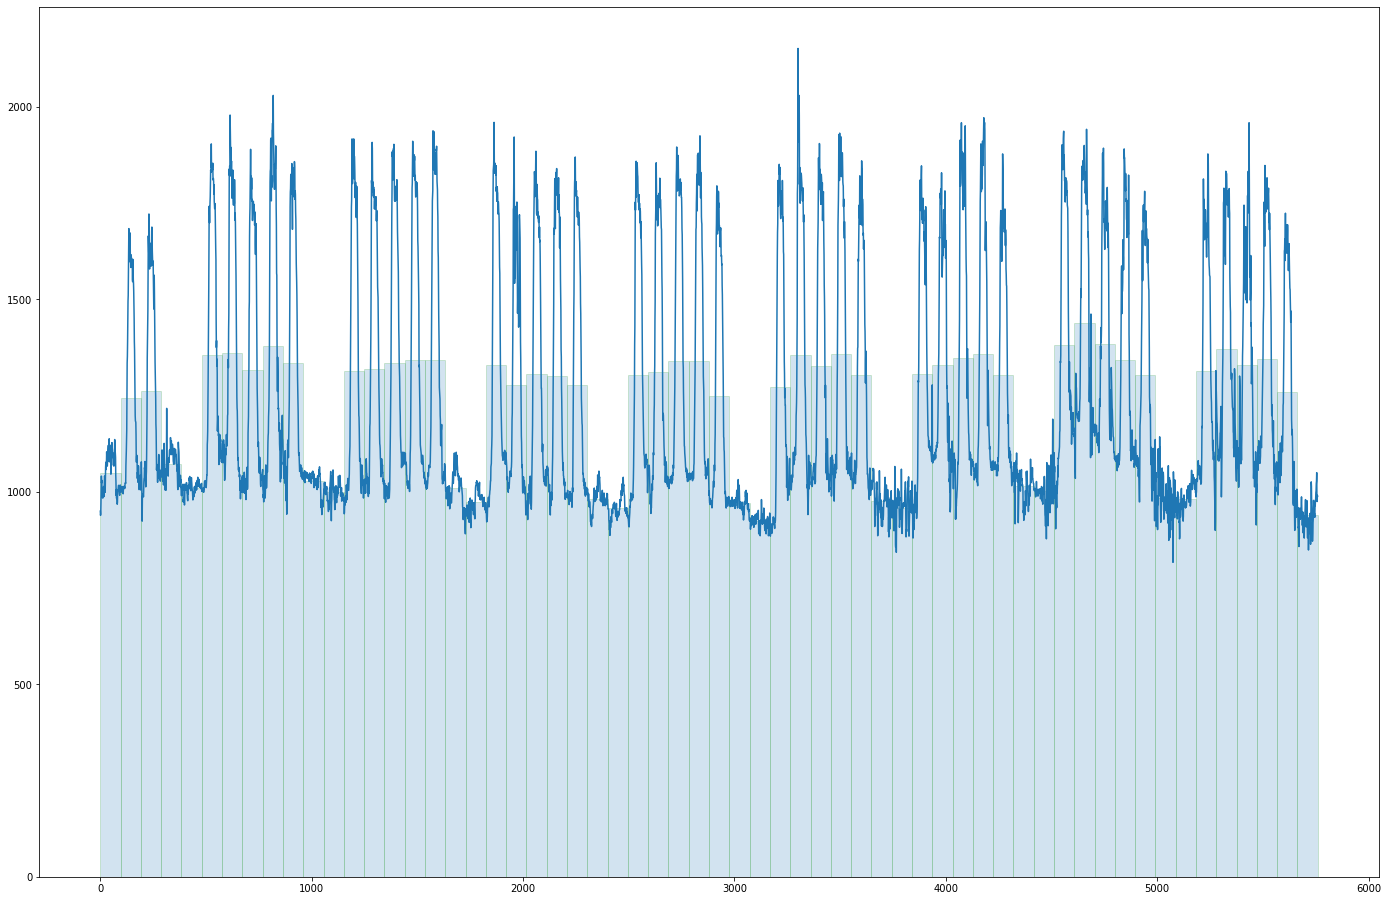

In [89]:
plt.close()
plt.plot(x[:DAY*60])
plt.bar(np.arange(0, DAY*60, DAY) + DAY/2, x_day[:60], width=DAY, alpha=0.2, edgecolor='C2')
plt.show()
# plt.savefig('a.svg')

Dalla morfologia del grafico è anche facile individuare quale giorno della settimana associare a ciascuna finestra da 96 campioni,
infatti è facile verificare visivamente che il primo giorno dell'anno è un mercoledì.

Sapendo ciò è possibile associare ad ogni finestra un determinato giorno della settimana in maniera automatica: di seguito
vengono raccolte tutte le finestre contenenti giorni del weekend nell'insieme 'holi'.


In [90]:
holi = set()
for idx, a in enumerate(x_day):
    if (idx+2) % 7 > 4:
       holi.add(idx)


Infine vengono cercate tutte le finestre dei campioni raccolti durante i giorni festivi e aggiunte all'insieme 'holi'.

In [91]:
holidays_netherlands = holidays.CountryHoliday('Netherlands')
holi_array = []

YEAR = 1997
for d in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='1D'):
    if d in holidays_netherlands:
        print(d, holidays_netherlands.get(d), d.dayofyear)
        holi.add(d.dayofyear - 1)
for number in holi:
    holi_array.append(number)
holi = np.array(holi_array)


1997-01-01 00:00:00 Nieuwjaarsdag 1
1997-03-28 00:00:00 Goede Vrijdag 87
1997-03-30 00:00:00 Eerste paasdag 89
1997-03-31 00:00:00 Tweede paasdag 90
1997-04-30 00:00:00 Koninginnedag 120
1997-05-08 00:00:00 Hemelvaart 128
1997-05-18 00:00:00 Eerste Pinksterdag 138
1997-05-19 00:00:00 Tweede Pinksterdag 139
1997-12-25 00:00:00 Eerste Kerstdag 359
1997-12-26 00:00:00 Tweede Kerstdag 360


Una volta fatto ciò è possibile rappresentare tramite degli istogrammi blu la media dei consumi di ciascuna finestra e nel caso
in cui questi consumi appartenessero alle finestre di 'holi', questi verranno sovrapposti con un istogramma rosso.
Facendo ciò, è facile individuare i giorni anomali.


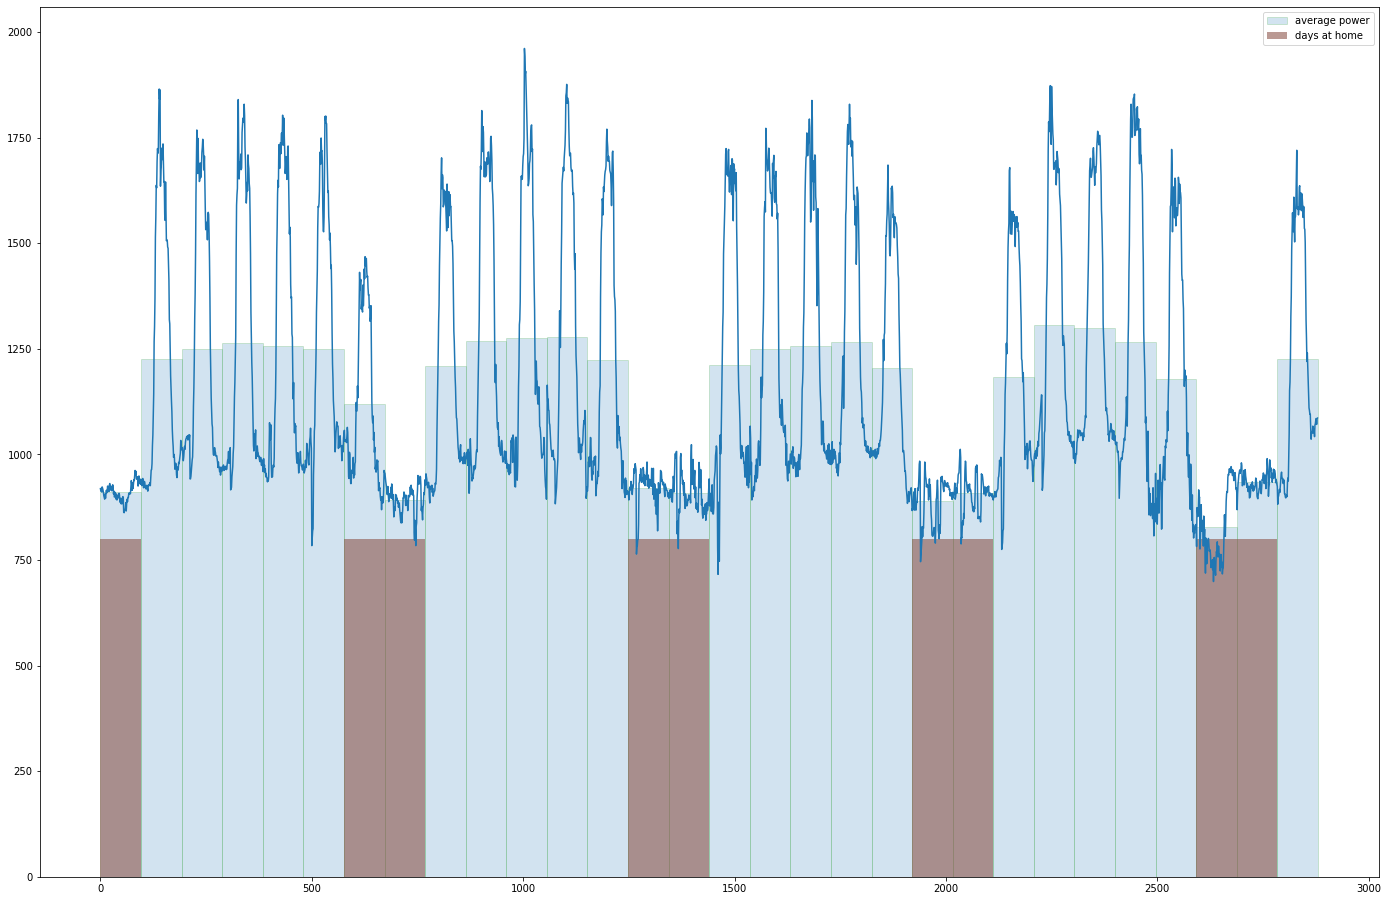

In [92]:
def findIndex(array, LIM, comparator):
    index = 0
    for element in array:
        if comparator(element, LIM):
            return index
        else:
            index += 1
    return index

LIML = 270
LIMR = 300

holi_right = findIndex(holi, LIMR, (lambda x, y: x >= y))
holi_left = findIndex(holi, LIML, (lambda x, y: x >= y))

plt.close()
plt.plot(x[DAY*LIML:DAY*LIMR])
plt.bar(np.arange(0, DAY*(LIMR-LIML), DAY) + DAY/2, x_day[LIML:LIMR], width=DAY, alpha=0.2, edgecolor='C2', label="average power")

plt.bar((holi[holi_left : holi_right] - LIML) * DAY + DAY/2, 800, width=DAY, alpha=0.6, color='C5', label="days at home")
plt.legend()
plt.show()


Di seguito, dato il numero(a partire da 0) associato ad uno degli istogrammi rappresentati è possibile ottenere la data
corrispondente, in questo modo è possibile determinare quali sono i giorni anomali a partire dal blocco considerato.


In [93]:
number_from_histogram = 6 + LIML
datesOfSample = [date for date in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='1D')]
print(datesOfSample[number_from_histogram])

1997-10-04 00:00:00


I giorni anomali individuati sono i seguenti:
- 1997-05-05 giorno lavorativo con consumi bassi.
- 1997-10-04 giorno festivo con consumi alti.



## Dataset italiano
Di seguito vengono analizzati i consumi di un determinato ufficio locato a Bergamo.

In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import holidays
#import seaborn as sns
#from catboost import CatBoostRegressor
#from sklearn import linear_model
#from sklearn.neural_network import MLPRegressor
%matplotlib inline

In [95]:
# Constant
FIG_SIZE = (16, 10)

### Preparazione del Dataset
Tra i dati letti all'interno del file csv, quelli che verranno effettivamente analizzati sono quelli provenienti dai Circuit Breaker 'First floor', 'Second floor' e 'Third floor'.

In [96]:
cb_target = [['CB Third Floor'], ['CB First Floor', 'CB Second Floor']]
cb_flat = sum(cb_target, [])
cb_flat

['CB Third Floor', 'CB First Floor', 'CB Second Floor']

In [97]:
dataset = pd.read_csv('AVGpower-1.csv', sep=';', parse_dates=['DateTime'])
dataset = dataset.astype({'AvgP':'int16', 'AvgT':'float32', 'AvgH':'float32'})
dataset

,DateTime,CbTagName,AvgP,AvgT,AvgH
0,2017-01-01 00:15:00,Bridge,0,0.0,0.000000
1,2017-02-06 00:00:00,CB Second Floor,0,3.5,98.599998
2,2017-02-06 00:00:00,CB First Floor,0,3.5,98.599998
3,2017-02-06 00:00:00,CB Backup A,0,3.5,98.599998
4,2017-02-06 00:00:00,CB Back Up C,0,3.5,98.599998
...,...,...,...,...,...
437559,2019-04-10 15:30:00,CB Backup A,0,18.1,52.599998
437560,2019-04-10 15:30:00,CB First Floor,68,18.1,52.599998
437561,2019-04-10 15:30:00,CB Back Up C,0,18.1,52.599998
437562,2019-04-10 15:30:00,Bridge,0,18.1,52.599998


In [98]:
# Preparazione dataset
train = dataset[dataset['CbTagName']=='CB First Floor'].set_index('DateTime')
d1 = dataset[dataset['CbTagName']=='CB Second Floor'].set_index('DateTime')
d2 = dataset[dataset['CbTagName']=='CB Third Floor'].set_index('DateTime')
train = train.join(d1, lsuffix='', rsuffix='2', how='inner')
train = train.join(d2, lsuffix='1', rsuffix='3', how='inner')
train.drop(columns=['AvgT2', 'AvgT3', 'AvgH2', 'AvgH3', 'CbTagName1', 'CbTagName2', 'CbTagName3'], inplace=True)
train.rename(columns={'AvgT1':'AvgT', 'AvgH1':'AvgH'}, inplace=True)
train['DateTime'] = train.index

### Correzione del Dataset
Dall'analisi dei dati emerge che la frequenza di campionamento è di 15 minuti, tuttavia è stata notata la mancanza di aluni campioni all'interno del dataset:
per risolvere questo problema si è scelto di introdurre dei campioni fittizi per colmare le mancanze.
<br>
Poichè in certi casi i dati mancanti possono essere 'contigui', la scelta di interpolare dei dati non può essere sempre considerata, di conseguenza si è preferito inserire i valori dei campioni che precedono il campione mancante di esattamente una settimana. L'interpolazione dei dati è stata adottata esclusivamente per correggere la prima settimana di campionamento, in quanto anche essa presenta dei dati mancanti ma molto sparsi, condizione apprezzabile per applicare l'interpolazione: quest'ultima è fondamentale, in quanto non sarebbe possibile colmare le mancanze successive, poichè si rischierebbe di copiare un valore inesistente.


In [99]:
# aggiunta punti mancanti
new_row = {name:[] for name in train.columns}
for date in pd.date_range(start='2017-02-08', end='2017-02-15', freq='15Min'):
    if date not in train['DateTime']:
        print(date)
        new_row['DateTime'].append(date)
        for name in train.columns:
            if name != 'DateTime':
                new_row[name].append(np.nan)

train = pd.concat([train, pd.DataFrame(new_row)])
train = train.set_index('DateTime')
train.interpolate(inplace=True)
train['DateTime'] = train.index

new_row = {name:[] for name in train.columns}
for date in pd.date_range(start='2017-02-15', end=train['DateTime'].max(), freq='15Min'):
    if date not in train['DateTime']:
        #print(date)
        new_row['DateTime'].append(date)
        for name in train.columns:
            if name != 'DateTime':
                new_row[name].append(np.nan)
train = pd.concat([train, pd.DataFrame(new_row)])
train = train.set_index('DateTime')

train.sort_index(inplace=True)

for i in range(672, len(train)):
    if np.isnan(train.iloc[i].AvgP1):
        train.iloc[i] = train.iloc[i-672]
train['DateTime'] = train.index

2017-02-08 02:15:00
2017-02-12 00:00:00
2017-02-12 18:00:00
2017-02-12 18:30:00
2017-02-12 19:15:00
2017-02-12 19:45:00
2017-02-12 21:00:00
2017-02-13 04:15:00
2017-02-13 05:45:00
2017-02-13 06:15:00
2017-02-13 06:45:00
2017-02-13 07:15:00
2017-02-13 08:15:00
2017-02-13 08:45:00
2017-02-13 09:15:00


In [100]:
# giorni di vacanza
holidays_it = holidays.Italy()
train['holidays'] = train['DateTime'].apply(lambda x: x in holidays_it).astype('int8')
# giorno della settimana
train['dayofweek'] = train['DateTime'].dt.dayofweek

### Dati terzo piano
I dati del terzo piano non sono particolarmente significativi per poter individuare anomalie all'interno dei giorni festivi e lavorativi, in quanto gli impianti di riscaldamento e di raffreddamento sono accesi indipendentemente dal tipo di giorno.
I dati fanno notare come i consumi legati al riscaldamento dipendano per lo più dalle stagioni come si può notare dal grafico:
mediamente i consumi più bassi si hanno durante la primavera poichè le temperature sono più miti.
<br>
Per questo motivo si è scelto di studiare più nel dettaglio l'andamento dei consumi elettrici del **secondo piano** dove vengono registrati i consumi relativi alla luce.

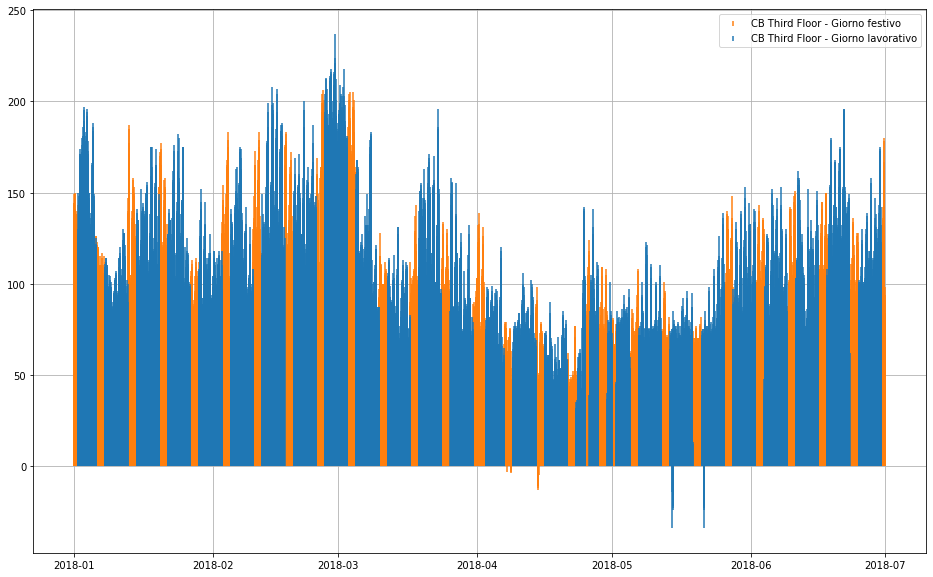

In [101]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.year == 2018]
curr_dataset = curr_dataset[(1 <= curr_dataset['DateTime'].dt.month)&(curr_dataset['DateTime'].dt.month <= 6)]
#curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.day < 12]


curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP3'], label='CB Third Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP3'], label='CB Third Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

ax.grid()
ax.legend()
plt.show()


### Dati anomali

All'interno di questo dataset sono state riscontrate alcune anomalie:
- 24/04/2017 giorno lavorativo con consumi bassi: i due giorni precedenti sono weekend mentre il giorno successivo è un festivo, si presume che questo giorno sia un ponte.
- 14/08/2017 giorno lavorativo con consumi bassi: i due giorni precedenti sono weekend mentre il giorno successivo è un festivo, si presume che questo giorno sia un ponte.
- 16/08/2017 e 17/08/2017 giorni lavorativi con bassi consumi: si presume che siano giorni di vacanza di ferragosto.
- 27/12/2017 28/12/2017 29/12/2017 giorni lavorativi con consumi bassi: si presume siano giorni di vacanze natalizie.
- 01/01/2018 fino a 08/01/2018 giorni lavorativi con consumi medio bassi: si presume che alcuni dipendenti abbiano preso ferie tra capodanno e l'epifania.
- 30/04/2018 giorno lavorativo con consumi bassi: i due giorni precedenti sono weekend mentre il giorno successivo è un festivo, si presume che questo giorno sia un ponte.
- 15/08/2018 giorno festivo con consumi elevati: i dati di questo giorno in realtà sono quelli del 08/08/2018 che è un giorno lavorativo in quanto i dati reali del 15/08/2018 sono mancanti.
- 13/08/2018 e 14/08/2018 giorni lavorativi con bassi consumi: essendo giorni precedenti a quello di ferragosto si presume che i dipendenti abbiano preso ferie per le vacanze di ferragosto.
- 02/11/2018 giorno lavorativo con consumi bassi: i due giorni successivi sono weekend mentre il giorno precedente è un festivo, si presume che questo giorno sia un ponte.
- 26/12/2018 giorno festivo con picchi di consumi elevati: è difficile dare una spiegazione a questa anomalia.

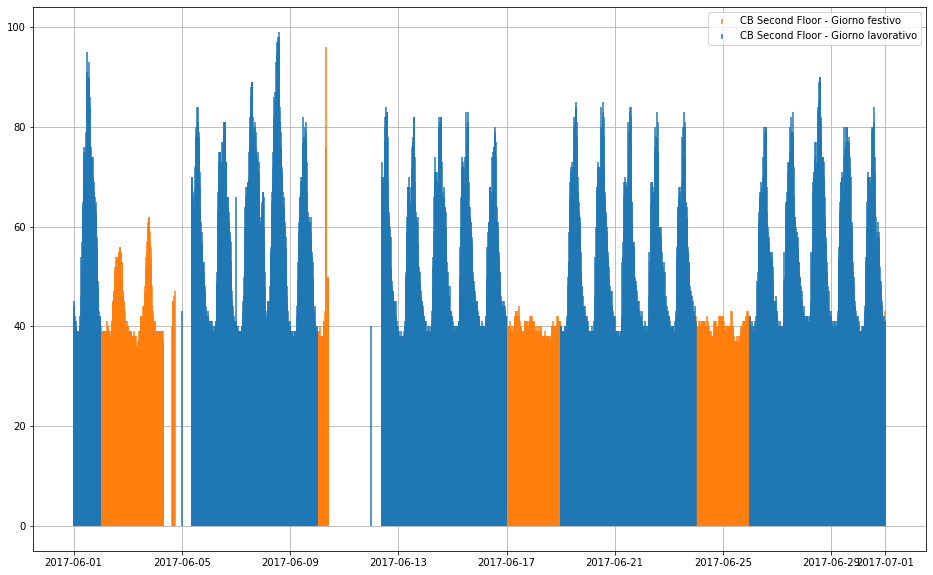

In [102]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[('2017-06-01' <= curr_dataset['DateTime'])&(curr_dataset['DateTime'] <= '2017-07-01')]
# curr_dataset = curr_dataset[('2017-08-01' <= curr_dataset['DateTime'])&(curr_dataset['DateTime'] <= '2017-09-01')]

#curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.day < 12]


curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP2'], label='CB Second Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP2'], label='CB Second Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

ax.grid()
ax.legend()
plt.show()


### Anomalie Terzo piano
Nonostante il terzo piano non sia particolarmente significativo, si è notata la presenza di dati anomali, ovvero potenze **negative** che offrono un interessante spunto di riflessione.

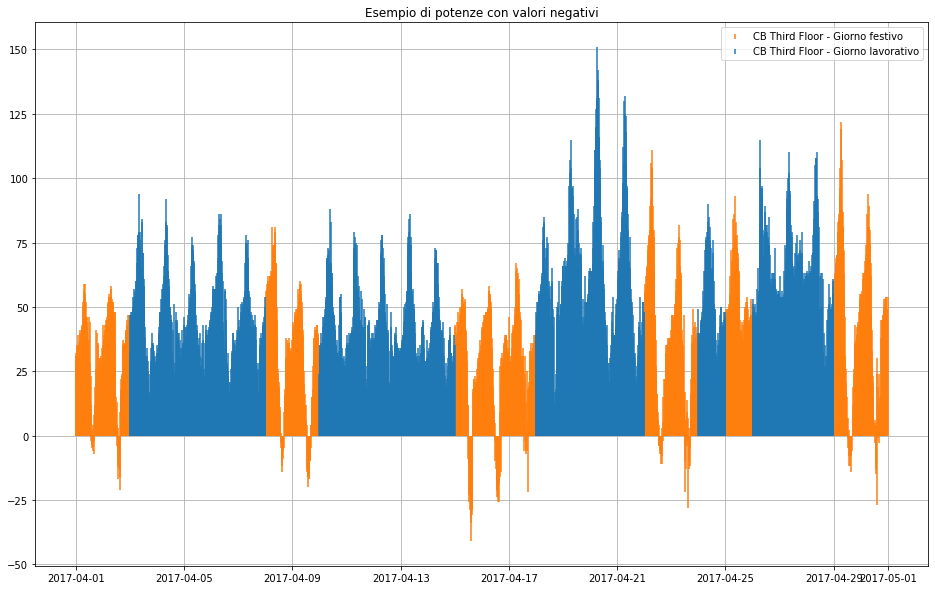

In [103]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
curr_dataset = train
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.year == 2017]
curr_dataset = curr_dataset[curr_dataset['DateTime'].dt.month == 4]

curr_holidays = curr_dataset[(curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5)]
curr_not_holidays = curr_dataset[~((curr_dataset['holidays'] == 1)|(curr_dataset['dayofweek']>=5))]


ax.stem(curr_holidays.index, curr_holidays['AvgP3'], label='CB Third Floor - Giorno festivo', linefmt='C1', markerfmt=' ', basefmt=' ')
ax.stem(curr_not_holidays.index, curr_not_holidays['AvgP3'], label='CB Third Floor - Giorno lavorativo', linefmt='C0', markerfmt=' ', basefmt=' ')

#ax.plot(curr_dataset.index, curr_dataset['holidays'], label='hol')

ax.grid()
ax.legend()
plt.title("Esempio di potenze con valori negativi", fontdict=None, loc='center', pad=None)
plt.show()

Questi dati anomali presentano alcune caratteristiche comuni:
- non compaiono mai nelle giornate lavorative.
- compaiono solo nella fascia oraria 10-17.
- compaiono principalmente nei mesi di primavera.


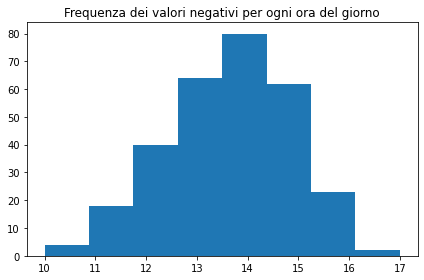

In [104]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
hours = train[train['AvgP3']<0]['DateTime'].dt.hour
ax.hist(hours, bins=len(hours.unique()))
plt.title("Frequenza dei valori negativi per ogni ora del giorno", fontdict=None, loc='center', pad=None)
plt.show()

Questi pattern portano ad ipotizzare che l'ufficio potrebbe essere dotato di pannelli fotovoltaici e i valori di potenza negativa potrebbero indicare che i consumi dell'edificio sono minori rispetto all'energia prodotta dai pannelli, come suggerito dal sito https://ctlsys.com/support/negative_power_values/:

" There are a few different reasons for negative power readings:

- One or more CTs are installed backwards. CTs have a label or arrow that should point towards the source of power (generally the transformer, breaker, or fuse).
- ***This is a bidirectional power measurement application, such as a photovoltaic system, where negative power occurs whenever you generate more power than you consume. In this case, there is nothing wrong with the negative power readings, so long as they occur when power is being generated.***
- The current transformers are installed so that the phases don’t match the voltage phases. For example, suppose the CTs are shifted by one phase, so that instead of monitoring phases A, B, and C (in that order), the CTs are on B, C, and A. This will generally result in negative power or a very low power factor. "

In conclusione si è scelto di considerare corretti questi valori.




## 'A Novel Approach for Anomaly Detection in Power Consumption Data'

### Introduzione

In questa sezione si è deciso di confrontare il paper 'A Novel Approach for Anomaly Detection in Power
Consumption Data' di C. Chahla, H. Snoussi, L. Merghem e M. Esseghir.

### Approccio proposto
Il paper citato propone due metodologie distinte per riconoscere i consumi anomali:
- approccio ibrido utilizzando k-means e LSTM
- autoencoder

#### K-means & LSTM
Nel primo caso viene proposto di rappresentare ciascuna ora di campionamento con le 24 ore precedenti e di creare 24
gruppi di campioni, dove all'interno dell'i-esimo gruppo vengono inseriti i campioni rappresentanti l'i-esima ora.
All'interno di ciascun gruppo viene applicato l'algoritmo di k-means per individuare quali sono i comportamenti considerati
normali per ciascuna ora. Una volta fatto ciò viene utilizzato un LSTM che prende come ingresso i consumi delle ultime 24 ore
per prevedere i consumi dell'ora successiva: ottenuta la previsione è possible creare un vettore contenente i dati
delle ultime 23 ore e i consumi previsti dell'ora successiva e verificare quale sia il cluster più vicino. Se il vettore
ottenuto dista più di una distanza massima definita da ciascun cluster, si può supporre che l'ora prevista sia anomala.
Il vantaggio di questo approccio è dato dalla possibilità di prevedere con un anticipo di un'ora la presenza di consumi anomali.

#### Autoencoder
Il secondo approccio suggerisce di rappresentare i giorni come vettori contenenti 24 campioni, dove l'i-esimo campione rappresenta
il consumo all'i-esima ora. Utilizzando un autoencoder è possibile riconoscere i giorni con consumi anomali in base all'errore di
ricostruzione del giorno: se l'errore di ricostruzione è alto, è lecito aspettarsi che il giorno sia anomalo.

### Problematiche
Sebbene entrambi i metodi siano validi, essi non sono dei metodi completi, infatti entrambi sono in grado di riconoscere
un giorno anomalo nel momento in cui si presentano dei picchi di consumo particolarmente elevati, ma non sono in grado di distinguere i
giorni lavorativi da quelli festivi: questo significa che un giorno lavorativo con consumi di un tipico giorno festivo non
verrebbe riconosciuto come un'anomalia.

### Soluzione
Per far fronte alle problematiche evidenziate si è deciso di utilizzare degli approcci alternativi, di seguito vengono
elencati i metodi proposti:
- Doppio autoencoder: anziché utilizzare un unico autoencoder si è deciso di utilizzare un autoencoder per ciascun tipo di giornata,
ovvero uno per riconoscere i giorni festivi anomali e l'altro per i giorni lavorativi anomali.
- K-means con 2 centroidi: ad un centroide vengono associati i giorni lavorativi, mentre al rimanente i giorni festivi.
- LSTM con input settimanali: anziché prevedere i consumi dell'ora successiva, si propone di prevedere i consumi del giorno
successivo, dati i consumi degli ultimi sette giorni, in modo tale da poter riconoscere la periodicità settimanale.

In [105]:
import math
import numpy as np
import matplotlib.pyplot as plt
import holidays
import pandas as pd
import random

%matplotlib inline


Per fare l'analisi di anomalie si è deciso di utilizzare il dataset dell'Olanda('power_data_eamonn-1.txt').
Una volta letti i dati, questi vengono scalati e distribuiti su valori che vanno da 0 a 1, in modo tale da avere dei risultati
migliori.

### Data preparation per Autoencoder e k-means

In [106]:
plt.rcParams["figure.figsize"] = (24,16)
with open('power_data_eamonn-1.txt', 'r') as f:
    samples = f.readlines()
#x
samples = np.array([int(i) for i in samples if i != '\n'])
samples = samples / samples.max()
DAY = 96

Di seguito vengono riportate le date anomale che sono state individuate durante l'analisi dei dati dell'Olanda.

05/05/1997 è un giorno lavorativo con valori di consumo bassi, mentre 04/10/1997 è un giorno festivo con valori di consumo
alti.
I giorni lavorativi anomali vengono raggruppati in wrongHolidays, mentre i giorni lavorativi anomali in wrongWorkingDays.

In [107]:
def append_anomalous_day(list_of_days, day):
    day = day.split('/')
    day = day[2] + "-" + day[1] + "-" + day[0]
    listOfSamples = [x for x in pd.date_range(start=day+" 00:00", end=day+" 23:59", freq="1d")]
    for x in listOfSamples:
        list_of_days.append(x)
    return list_of_days

wrongWorkingDays = [
    "05/05/1997"
]

wrongHolidays = [
    "04/10/1997"
]


anomalousWorkingDays = []
for x in wrongWorkingDays:
    anomalousWorkingDays = append_anomalous_day(anomalousWorkingDays, x)
print("anomalous working days are {}".format(len(anomalousWorkingDays)))

anomalousHolidays = []
for x in wrongHolidays:
    anomalousHolidays = append_anomalous_day(anomalousHolidays, x)
print("anomalous holidays are {}".format(len(anomalousHolidays)))


anomalous working days are 1
anomalous holidays are 1


Ora vengono letti tutti i dati e divisi in modo tale da avere due liste distinte: la prima conterrà i campioni dei giorni lavorativi,
mentre la seconda i campioni dei giorni festivi. Per evitare di avere un training contaminato dalle anomalie, i campioni dei
giorni anomali non verranno inseriti all'interno delle liste descritte precedentemente, ma in 'anomalous_work_samples'
e 'anomalous_holiday_samples'.

Per controllare se un giorno è anomalo o meno, si è deciso di dare come dato di ingresso un vettore di 24 campioni sia all'algortimo
k-means che all'autoencoder. Siccome la frequenza di campionamento è di 1 campione ogni 15 minuti, l'elemento i-esimo del vettore
sarà la media dei 4 campioni registrati durante l'ora i-esima.

In [108]:
YEAR = 1997
SAMPLES_PER_HOUR = 4

holidays_netherlands = holidays.CountryHoliday('Netherlands', YEAR)
holidays_samples = []
work_samples = []
anomalous_work_samples = []
anomalous_holiday_samples = []


starting_window = 0
for date in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='1D'):
    day_sample = []
    for i in range(24):
        hour_sample = samples[starting_window + SAMPLES_PER_HOUR * i : starting_window + SAMPLES_PER_HOUR * ( i + 1)].mean()
        day_sample.append(hour_sample)
    if date in anomalousWorkingDays:
        anomalous_work_samples.append(day_sample)
    elif date in anomalousHolidays:
        anomalous_holiday_samples.append(day_sample)
    elif date in holidays_netherlands or date.day_of_week == 5 or date.day_of_week == 6:
        holidays_samples.append(day_sample)
    else:
        work_samples.append(day_sample)
    starting_window += 96


Di seguito vengono preparati i training set e i testing set che verranno adottati per poter allenare i modelli di autoencoder
e k-means.
Si è deciso di utilizzare l'80% dei dati come training set, mentre il rimanente 20% come testing set.

In [109]:
work_samples_shuffled = work_samples
holiday_samples_shuffled = holidays_samples
random.shuffle(work_samples_shuffled)
random.shuffle(holiday_samples_shuffled)

PERCENTAGE = 0.8
work_train = []
holiday_train = []
work_test = []
holiday_test = []
all_samples = []

work_size_train = int(PERCENTAGE * len(work_samples))
for index in range(work_size_train):
    work_train.append(work_samples_shuffled[index])
    all_samples.append(work_samples_shuffled[index])
for index in range(work_size_train, len(work_samples)):
    work_test.append(work_samples_shuffled[index])

holiday_size_train = int(PERCENTAGE * len(holidays_samples))
for index in range(holiday_size_train):
    holiday_train.append(holiday_samples_shuffled[index])
    all_samples.append(holiday_samples_shuffled[index]);
for index in range(holiday_size_train, len(holidays_samples)):
    holiday_test.append(holiday_samples_shuffled[index])

print("size of work_train is {}".format(len(work_train)))
print("size of work_test is {}".format(len(work_test)))
print("size of holiday_train is {}".format(len(holiday_train)))
print("size of holiday_test is {}".format(len(holiday_test)))


size of work_train is 201
size of work_test is 51
size of holiday_train is 88
size of holiday_test is 23


### Autoencoder

Per poter individuare delle anomalie è possibile utilizzare due autoencoder:
il primo verrà allenato con lo scopo di riconoscere i giorni lavorativi normali, mentre il secondo per riconoscere i giorni
festivi normali.

Dati i campioni di un determinato giorno è possibile sapere se sono stati raccolti durante un giorno festivo o lavorativo e di
conseguenza usare l'autoencoder corretto: se l'autoencoder è in grado di ricostruire correttamente i consumi, allora il giorno
analizzato potrà essere considerato normale, altrimenti anomalo.

#### Autoencoder per riconoscere i giorni lavorativi

In [110]:
from tensorflow import keras

SIZE_SAMPLE = 24
#enconder
activationMode = 'swish'
encoderInputWork = keras.Input(shape=SIZE_SAMPLE)
firstLayerEncoderWork = keras.layers.Dense(50, activation=activationMode, name="1")(encoderInputWork)
secondLayerEncoderWork = keras.layers.Dense(20, activation=activationMode, name="2")(firstLayerEncoderWork)
encoderOutputWork = keras.layers.Dense(2, activation=activationMode, name="3")(secondLayerEncoderWork)

#decoder
firstLayerDecoderWork = keras.layers.Dense(20, activation=activationMode, name="4")(encoderOutputWork)
secondLayerDecoderWork = keras.layers.Dense(50, activation=activationMode, name="5")(firstLayerDecoderWork)
decoderOutputWork = keras.layers.Dense(24, activation=activationMode, name="6")(secondLayerDecoderWork)

#auto encoder
autoEncoderWork = keras.Model(encoderInputWork, decoderOutputWork)
autoEncoderWork.compile(optimizer='Adam', loss='mean_squared_error')
autoEncoderWork.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
1 (Dense)                    (None, 50)                1250      
_________________________________________________________________
2 (Dense)                    (None, 20)                1020      
_________________________________________________________________
3 (Dense)                    (None, 2)                 42        
_________________________________________________________________
4 (Dense)                    (None, 20)                60        
_________________________________________________________________
5 (Dense)                    (None, 50)                1050      
_________________________________________________________________
6 (Dense)                    (None, 24)                1224

Una volta costruito il modello è possibile allenarlo con il training set contenente i campioni di *soli* giorni lavorativi
nominali.

In [111]:
BATCH_SIZE = 64
train = np.array(work_train)
autoEncoderWork.fit(train, train, epochs=40, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)


Per verificare che il modello si comporti correttamente, vengono fatte delle previsioni usando il testing set contenente
campioni di soli giorni lavorativi e di seguito viene calcolato l'MSE tra i campioni ricostruiti e i campioni originali.

score: 0.024788082896170235


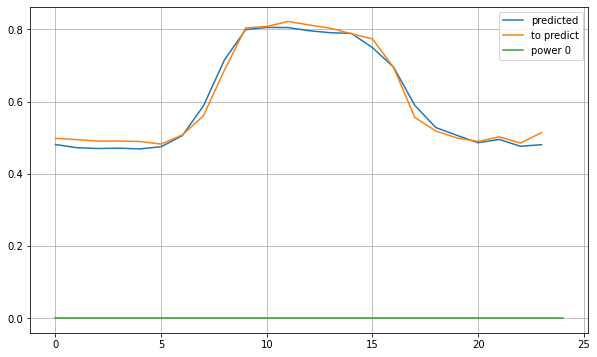

In [112]:
from sklearn import metrics

predictedValues = autoEncoderWork.predict(work_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, work_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(work_test[index]))], work_test[index], label='to predict')
ax.plot([0, len(work_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()


Come si può notare dai valori dell'MSE e dal grafico, il modello sembra ricostruire fedelmente i giorni lavorativi, tuttavia, per
avere la certezza che il modello riesca ad individuare correttamente le anomalie è necessario testarlo anche con il testing set
contenente giorni festivi normali: se l'MSE risulta molto più alto rispetto all'MSE precedentemente calcolato, allora si può assumere
che il modello funzioni correttamente.

score: 0.10078057551734618


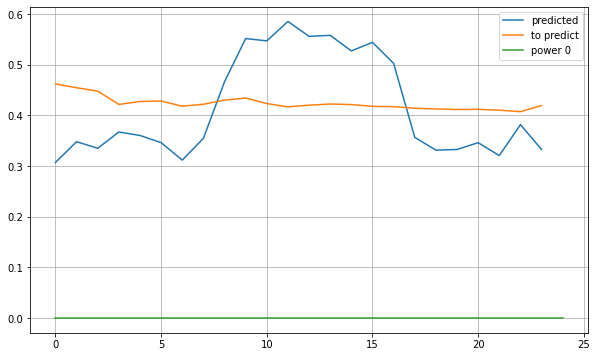

In [113]:

predictedValues = autoEncoderWork.predict(holiday_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, holiday_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(holiday_test[index]))], holiday_test[index], label='to predict')
ax.plot([0, len(holiday_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

Sia dal grafico che dall'MSE ottenuto(circa cinque volte quello precedentemente calcolato) risulta evidente come il modello
non sia in grado di ricostruire giorni lavorativi anomali.

#### Autoencoder per riconoscere giorni festivi anomali
Per riconoscere le anomalie tra i giorni festivi è possibile effettuare gli stessi passaggi per allenare un nuovo autoencoder
a ricostruire giorni festivi normali.

In [114]:
SIZE_SAMPLE = 24
#enconder
activationMode = 'swish'
encoderInputHoliday = keras.Input(shape=SIZE_SAMPLE)
firstLayerEncoderHoliday = keras.layers.Dense(50, activation=activationMode, name="1")(encoderInputHoliday)
secondLayerEncoderHoliday = keras.layers.Dense(20, activation=activationMode, name="2")(firstLayerEncoderHoliday)
encoderOutputHoliday = keras.layers.Dense(2, activation=activationMode, name="3")(secondLayerEncoderHoliday)

#decoder
firstLayerDecoderHoliday = keras.layers.Dense(20, activation=activationMode, name="4")(encoderOutputHoliday)
secondLayerDecoderholiday = keras.layers.Dense(50, activation=activationMode, name="5")(firstLayerDecoderHoliday)
decoderOutputHoliday = keras.layers.Dense(24, activation=activationMode, name="6")(secondLayerDecoderholiday)

#auto encoder
autoEncoderHoliday = keras.Model(encoderInputHoliday, decoderOutputHoliday)
autoEncoderHoliday.compile(optimizer='Adam', loss='mean_squared_error')
autoEncoderHoliday.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
1 (Dense)                    (None, 50)                1250      
_________________________________________________________________
2 (Dense)                    (None, 20)                1020      
_________________________________________________________________
3 (Dense)                    (None, 2)                 42        
_________________________________________________________________
4 (Dense)                    (None, 20)                60        
_________________________________________________________________
5 (Dense)                    (None, 50)                1050      
_________________________________________________________________
6 (Dense)                    (None, 24)                1224

Il modello viene allenato con holiday_train, ovvero campioni di soli giorni festivi nominali.

In [115]:
BATCH_SIZE = 64
train = np.array(holiday_train)
autoEncoderHoliday.fit(train, train, epochs=40, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)


Di seguito viene calcolato l'MSE tra i valori originali e previsti dei giorni di holiday_test.

score: 0.01804967400206078


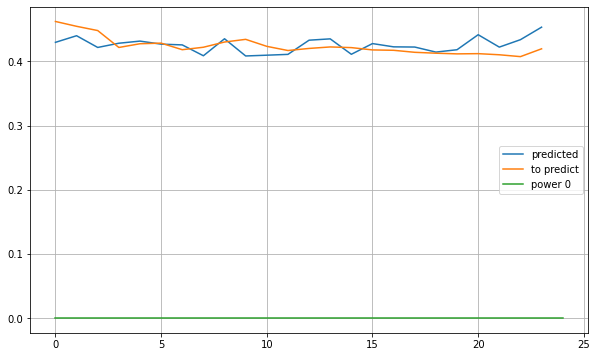

In [116]:
predictedValues = autoEncoderHoliday.predict(holiday_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, holiday_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(holiday_test[index]))], holiday_test[index], label='to predict')
ax.plot([0, len(holiday_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()


Il test mostra che l'errore misurato tramite l'MSE è intorno al 2%.

score: 0.15625025160833125


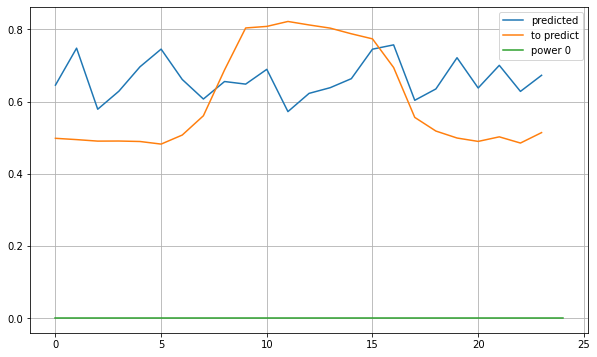

In [117]:

predictedValues = autoEncoderHoliday.predict(work_test)
score = np.sqrt(metrics.mean_squared_error(predictedValues, work_test))
print("score: {}".format(score))

index = 10

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[index]))], predictedValues[index], label="predicted")
ax.plot([x for x in range(0, len(work_test[index]))], work_test[index], label='to predict')
ax.plot([0, len(work_test[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

Testando il secondo autoencoder con i giorni di work_test, è possibile notare come l'MSE calcolato sia circa 7 volte maggiore
rispetto a quello calcolato precedentemente, di conseguenza è possibile assumere che il secondo autoencoder non sia in
grado di ricostruire giorni festivi anomali.

#### Tolleranze
Basandosi sulle osservazioni degli errori di ricostruzione dei singoli dati(sia anomali che non) è possibile stabilire una
tolleranza sopra la quale una ricostruzione è da considerarsi errata e che quindi il giorno ricostruito sia anomalo.

Di seguito vengono utilizzati 10 giorni festivi anomali e 10 festivi nominali per decidere la soglia per il secondo autoencoder.

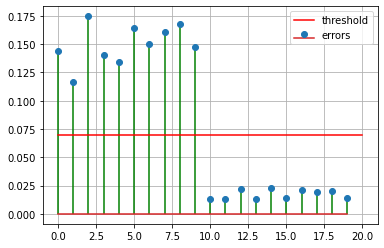

In [118]:
holidays_errors = []

for x in range(10):
    predicted = autoEncoderHoliday.predict([work_test[x]])
    holidays_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], work_test[x])))
for x in range(10):
    predicted = autoEncoderHoliday.predict([holiday_test[x]])
    holidays_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], holiday_test[x])))

THREASHOLD_HOLIDAY = 0.07

fig, ax = plt.subplots(figsize=(6, 4))
ax.stem([x for x in range(0, len(holidays_errors))], holidays_errors, 'g', label="errors")
ax.plot([0, len(holidays_errors)], [THREASHOLD_HOLIDAY, THREASHOLD_HOLIDAY], 'r', label="threshold" )
ax.grid()
ax.legend()
plt.show()


Infine vengono utilizzati 10 giorni lavorativi nominali e 10 giorni lavorativi anomali per determinare la soglia per il primo autoencoder:

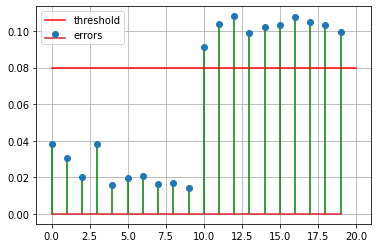

In [119]:
work_errors = []

for x in range(10):
    predicted = autoEncoderWork.predict([work_test[x]])
    work_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], work_test[x])))
for x in range(10):
    predicted = autoEncoderWork.predict([holiday_test[x]])
    work_errors.append(np.sqrt(metrics.mean_squared_error(predicted[0], holiday_test[x])))

THREASHOLD_WORK = 0.08

fig, ax = plt.subplots(figsize=(6,4))
ax.stem([x for x in range(0, len(work_errors))], work_errors, 'g', label="errors")
ax.plot([0, len(work_errors)], [THREASHOLD_WORK, THREASHOLD_WORK], 'r', label="threshold" )
ax.grid()
ax.legend()
plt.show()


Ora che sono stati allenati i modelli e sono state definite le soglie per determinare se un giorno è da considerarsi anomalo
o meno, è possibile creare una funzione che sia in grado di individuare delle anomalie.

is_anomalous_ae richiede come parametri 'd' e 'sample', dove 'd' è un oggetto pandas.date che rappresenta la data di campionamento,
mentre 'sample' è una lista di 24 campioni. La funzione restituisce un valore booleano, True se il giorno è anomalo, False altrimenti.

In [120]:
def is_anomalous_ae(d, sample):
    h = holidays.CountryHoliday('Netherlands', d.year)
    if d.day_of_week == 5 or d.day_of_week == 6 or d in h:
        prediction = autoEncoderHoliday.predict([sample])
        error = np.sqrt(metrics.mean_squared_error(prediction[0], sample))
        return error > THREASHOLD_HOLIDAY
    else :
        prediction = autoEncoderWork.predict([sample])
        error = np.sqrt(metrics.mean_squared_error(prediction[0], sample))
        return error > THREASHOLD_WORK


### K-MEANS

Il secondo approccio utilizzato per individuare delle anomalie è di utilizzare l'algoritmo k-means.
È possibile assumere che tutti i dati possano appartenere a due cluster: il primo rappresentante i giorni lavorativi, mentre
il secondo i giorni festivi.
Per individuare i centroidi verranno utilizzati nella fase di training sia i valori di work_train che di holiday_train.

In [121]:
from sklearn.cluster import KMeans

random.shuffle(all_samples)

N_CENTROIDS = 2
kmeans2 = KMeans(n_clusters=N_CENTROIDS, random_state=0).fit(all_samples)
label = kmeans2.predict(all_samples)
unique_labels = np.unique(label)

Siccome k-means a ogni run associa un'etichetta diversa allo stesso cluster, è necessario individuare i cluster dei giorni
lavorativi e festivi a run-time.

Viene fatta una previsione sui dati dei giorni lavorativi utilizzati per formare i cluster: l'etichetta dei giorni lavorativi
sarà quella restituita più spesso da k-means. La stessa operazione viene effettuata sui dati dei giorni festivi.

Se il clustering è stato effettuato correttamente, allora la maggior parte dei giorni festivi devono essere associati a una determinata etichetta,
mentre quelli lavorativi all'etichetta rimanente.

In [122]:
work_labels = kmeans2.predict(work_train)
holiday_labels = kmeans2.predict(holiday_train)

cluster_0_work = np.count_nonzero(work_labels == unique_labels[0])
cluster_1_work = np.count_nonzero(work_labels == unique_labels[1])

cluster_0_holiday = np.count_nonzero(holiday_labels == unique_labels[0])
cluster_1_holiday = np.count_nonzero(holiday_labels == unique_labels[1])

if cluster_0_work > cluster_1_work:
    real_label_work = 0
else:
    real_label_work = 1
if cluster_0_holiday > cluster_1_holiday:
    real_label_holiday = 0
else:
    real_label_holiday = 1
print("working days labeled with label 0 = {}".format(cluster_0_work))
print("working days labeled with label 1 = {}".format(cluster_1_work))
print("holidays labeled with label 0 = {}".format(cluster_0_holiday))
print("holidays labeled with label 1 = {}".format(cluster_1_holiday))


print("working days are labeled with {}".format(real_label_work))
print("holidays are labeled with {}".format(real_label_holiday))


working days labeled with label 0 = 201
working days labeled with label 1 = 0
holidays labeled with label 0 = 0
holidays labeled with label 1 = 88
working days are labeled with 0
holidays are labeled with 1


Una volta definite le labels dei cluster, è possibile determinare se un determinato giorno è anomalo o meno. Conoscendo il giorno
di campionamento, se la tipologia di giorno differisce dal cluster assegnato, allora il giorno analizzato è da
considerarsi anomalo.

In [123]:
prediction_anomalous_holiday = kmeans2.predict(anomalous_holiday_samples)[0]
prediction_anomalous_work = kmeans2.predict(anomalous_work_samples)[0]

print("Kmeans recognize an anomalous working day : {}".format(prediction_anomalous_work != real_label_work))
print("Kmeans recognize an anomalous holiday : {}".format(prediction_anomalous_holiday != real_label_holiday))

Kmeans recognize an anomalous working day : True
Kmeans recognize an anomalous holiday : True


La seguente funzione è in grado di individuare giorni anomali usando k-means

I parametri richiesti sono 'd' e 'samples' dove 'd' è un pandas.date object che rappresenta la data di campionamento, mentre
'samples' è un vettore di 24 campioni. Se il giorno è anomalo, la funzione restituisce True, altrimenti False.

In [124]:
def is_anomalous_kmeans(d, sample):
    h = holidays.CountryHoliday('Netherlands', d.year)
    prediction = kmeans2.predict(sample)
    if d.day_of_week == 5 or d.day_of_week == 6 or d in h:
        return prediction != real_label_holiday
    else :
        return prediction != real_label_work

### LSTM

Un altro metodo che può essere utilizzato per individuare giorni anomali può essere quello di utilizzare un LSTM che,
dati in ingresso i campioni degli ultimi sette giorni è in grado di prevedere i consumi del giorno successivo.
Confrontando i consumi previsti con i consumi effettivi, se l'errore risulta essere relativamente alto, allora è possibile stabilire
che il giorno analizzato è un'anomalia.

Allenare l'LSTM a riconoscere anomalie sapendo i consumi degli ultimi sette giorni equivale a determinare quale sia il prossimo
giorno della settimana data una sequenza di sette giorni: di conseguenza per poter avere delle previsioni accurate sarà necessario
utilizzare delle settimane che non contengano giorni anomali o festività.
Per comprendere meglio il problema, di seguito viene fornito un esempio.

Siano L un giorno con consumi bassi e H un giorno con consumi alti.

Data la sequenza L L H H H H H è lecito supporre che il giorno successivo sia un sabato.
Data la sequenza anomala L L L H H H H non è possibile stabilire il giorno successivo, infatti la sequenza L L L potrebbe
rappresentare la sequenza temporale Venerdì(festa), Sabato, Domenica oppure la sequenza Sabato, Domenica, Lunedì(festa), dunque
il giorno successivo potrebbe essere sia un Venerdì(giorno lavorativo) che un Sabato(giorno festivo).

In [125]:
#cleaning samples from weeks that contains an anomalous day
def append_elements_of_list(from_array, to_array):
    for element in from_array:
        to_array.append(element)

anomalous_days = []
append_elements_of_list(anomalousWorkingDays, anomalous_days)
append_elements_of_list(anomalousHolidays, anomalous_days)
append_elements_of_list(holidays_netherlands, anomalous_days)

I campioni di samples che non sono contenuti in settimane anomale, vengono copiati in nuovo vettore 'cleaned_samples'.

In [126]:
from datetime import timedelta

cleaned_samples = []
anomalous_weeks = []
start = 0
SPAN = DAY * 7
for date in pd.date_range(start=f'01-01-{YEAR}', end=f'31-12-{YEAR}', freq='7D'):
    is_anomalous_week = False
    for day_of_week in pd.date_range(start=date, end=(date + timedelta(days=7)), freq = '1D'):
        if day_of_week in anomalous_days:
            is_anomalous_week = True
    if not is_anomalous_week:
        append_elements_of_list(samples[start : start + SPAN], cleaned_samples)
    else:
        append_elements_of_list(samples[start : start + SPAN], anomalous_weeks)
    start += SPAN
cleaned_samples = np.array(cleaned_samples[: int(len(cleaned_samples) / SPAN) * SPAN])
cleaned_samples = cleaned_samples.reshape(1, cleaned_samples.shape[0])
print(cleaned_samples.shape)

(1, 29568)


Una volta rimossi i dati delle settimane anomale, vengono create le liste 'window_samples' e 'labels',
dove la prima è una lista di 56 elementi che rappresentano i consumi dell'ultima settimana, mentre la seconda è costituita
da 8 elementi che rappresentano i consumi del giorno successivo.

Come si può notare dai numeri, si assume che un campionamento avvenga ogni 3 ore per evitare di avere degli input troppo
granulari. Siccome il campionamento avviene ogni 15 minuti, ogni elemento i-esimo delle liste precedenti rappresenta una
media dei dati campionati nell'arco di 3 ore.

In [127]:
window_samples = []
labels = []
SAMPLES_PER_DAY = int(24 / 3)
WINDOW_SIZE = 7

for starting_window in range(0, len(cleaned_samples[0]), DAY):
    window = []
    label = []
    index = 0
    for x in range(WINDOW_SIZE * SAMPLES_PER_DAY):
        window.append(cleaned_samples[0][starting_window + SAMPLES_PER_HOUR * index : starting_window + SAMPLES_PER_HOUR * ( index + 3)].mean())
        index += 3
    for x in range(SAMPLES_PER_DAY):
        label.append(cleaned_samples[0][starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * index : starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * (index + 3)].mean())
        index += 3
    window_samples.append(window)
    labels.append(label)
labels = labels[: len(labels) - 14]
window_samples = window_samples[: len(window_samples) - 14]
print(len(window_samples))


294


<ipython-input-127-b2f958b1b6c8>:14: RuntimeWarning: Mean of empty slice.
  label.append(cleaned_samples[0][starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * index : starting_window + WINDOW_SIZE * DAY + SAMPLES_PER_HOUR * (index + 3)].mean())
c:\users\mvcim\onedrive\desktop\vlad\my_jupiter_notebooks\paper2\venv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-127-b2f958b1b6c8>:11: RuntimeWarning: Mean of empty slice.
  window.append(cleaned_samples[0][starting_window + SAMPLES_PER_HOUR * index : starting_window + SAMPLES_PER_HOUR * ( index + 3)].mean())


Di seguito viene rappresentata una settimana non anomala e il suo giorno successivo, ovvero l'input dell'LSTM e ciò che ci
si aspetta che sia in grado di prevedere.

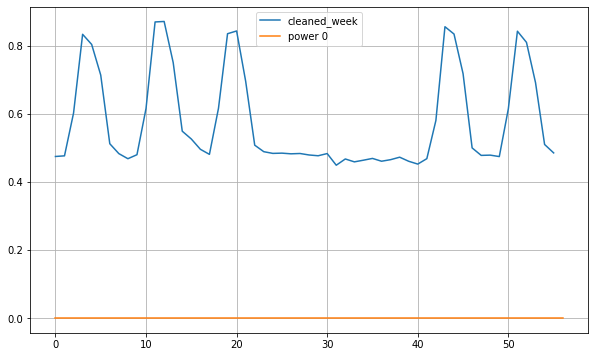

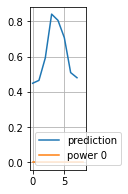

In [128]:
#plotting cleaned samples
index = 0
fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(window_samples[index]))], window_samples[index], label="cleaned_week")
ax.plot([0, len(window_samples[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(1,3))
ax.plot([x for x in range(0, len(labels[index]))], labels[index], label="prediction")
ax.plot([0, len(labels[index])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

A causa delle scarse dimensioni del dataset, il modello non è in grado di riconoscere correttamente
i consumi del sabato: anziché prevedere dei consumi bassi, vengono previsti dei consumi elevati come quelli di un giorno
lavorativo. Per far fronte a questa problematica si è deciso di utilizzare una tecnica di data augmentation, ovvero
di raddoppiare le finestre settimanali che hanno i campioni
dei giorni che vanno dal sabato al venerdì e come valori da prevedere i consumi del sabato. Così facendo si va ad aumentare
significativamente il numero di dati necessari all'apprendimento dei consumi del sabato.

In [129]:
duplicated_windows = []
duplicated_labels = []

#duplicating some data that should anticipate a saturday.
for i in range(3, len(window_samples), 7):
    window_samples.append(window_samples[i])
    labels.append(labels[i])
    duplicated_windows.append(window_samples[i])
    duplicated_labels.append(labels[i])

append_elements_of_list(window_samples, duplicated_windows)
append_elements_of_list(labels, duplicated_labels)
window_samples = duplicated_windows
labels = duplicated_labels


Di seguito vengono create delle liste per il training e il testing del modello.

In [130]:
train_weeks = []
train_labels = []
testing_weeks = []
testing_labels = []

training_size = int(len(labels) * PERCENTAGE)
for index in range(training_size):
    train_weeks.append(window_samples[index])
    train_labels.append(labels[index])
for index in range(training_size, len(labels)):
    testing_weeks.append(window_samples[index])
    testing_labels.append(labels[index])


def search_nan(arr):
    for element in arr:
        for x in element:
            if math.isnan(x):
                return True
    return False


Gli LSTM layer richiedono degli input tridimensionali(samples, time steps, features), quindi il set di training deve
essere ridimensionato correttamente.

In [131]:
def reshape_set(set_to_convert, features):
    return set_to_convert.reshape((set_to_convert.shape[0], set_to_convert.shape[1], features))


train_weeks = np.array(train_weeks)
train_labels = np.array(train_labels)
testing_weeks = np.array(testing_weeks)
testing_labels = np.array(testing_labels)

print(search_nan(train_weeks))
print(search_nan(train_labels))
print(search_nan(testing_weeks))
print(search_nan(testing_labels))

FEATURES = 1

training_set = reshape_set(train_weeks, FEATURES)
testing_set = reshape_set(testing_weeks, FEATURES)

False
False
False
False


In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import LSTM, Dropout

ACTIVATION_MODE = 'tanh'
hourForecaster = Sequential()

BATCH_SIZE = 256
NUM_SAMPLES = len(training_set)
n_steps_in = 8 * 7
drop_out = 0.1

model = Sequential()
model.add(LSTM(100, activation=ACTIVATION_MODE, return_sequences=True, input_shape=(n_steps_in, FEATURES)))
model.add(Dropout(drop_out))
model.add(LSTM(100, activation=ACTIVATION_MODE))
model.add(Dropout(drop_out))
model.add(Dense(50, activation=ACTIVATION_MODE))
model.add(Dropout(drop_out))
model.add(Dense(20, activation=ACTIVATION_MODE))
model.add(Dropout(drop_out))
model.add(Dense(8, activation=ACTIVATION_MODE))

model.compile(optimizer = Adam(learning_rate=0.001), loss='mse')
#best parameters :  activation mode tanh
#                   learning rate = 0.001
#                   batch_size 256(with duplicated saturdays)
#                   loss mse
#dropout            0.1
#score              7,5%
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 56, 100)           40800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 56, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

In [133]:
model.fit(training_set, train_labels, epochs=60, verbose=0, validation_data=(testing_set, testing_labels))
#validation_data=(testing_set, testing_labels)

Per verificare che il training abbia funzionato, possiamo utilizzare il testing set e calcolare l'MSE tra le labels dei
test e le previsioni ottenute dal modello.

In [134]:
def convert_predicted_value(x):
    new_x = []
    for element in x:
        new_x.append(element[-1])
    return new_x

to_predict = testing_set
labels_to_predict = testing_labels
to_predict = to_predict.reshape((to_predict.shape[0], to_predict.shape[1], FEATURES))

predictedValues = model.predict(to_predict)

score = np.sqrt(metrics.mean_squared_error(predictedValues, labels_to_predict))
print("score: {}".format(score))


labels_to_predict = np.array(labels_to_predict)
labels_to_predict = labels_to_predict.reshape(1, labels_to_predict.shape[0] * labels_to_predict.shape[1])
predictedValues = predictedValues.reshape(1, predictedValues.shape[0] * predictedValues.shape[1])


score: 0.04064008617915293


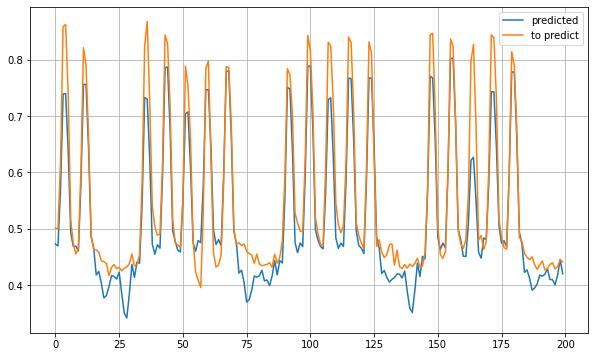

In [135]:
START = 0
END = 200

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([x for x in range(0, len(predictedValues[0][START:END]))], predictedValues[0][START:END], label="predicted")
ax.plot([x for x in range(0, len(labels_to_predict[0][START:END]))], labels_to_predict[0][START:END], label='to predict')
ax.grid()
ax.legend()
plt.show()



#### Soglia di tolleranza
Ora che è stato allenato correttamente il modello, bisogna determinare la soglia di errore per cui si può considerare che
il giorno previsto sia un'anomalia.
Di seguito vengono osservati 10 errori per previsioni corrette e 10 errori per previsioni errate.

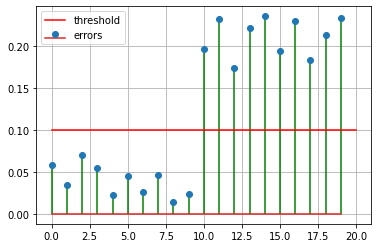

In [136]:
errors = []
span = 25
testing_set = testing_set.reshape(testing_set.shape[0], testing_set.shape[1])
for x in range(10):
    to_predict = np.array(testing_set[x + span])
    to_predict = to_predict.reshape(1, 56, 1)
    prevision = model.predict(to_predict)
    lbs = np.array(labels_to_predict)
    lbs = lbs.reshape(int(labels_to_predict.shape[1] / 8), 8)
    lb = np.array(lbs[x + span])
    lb = lb.reshape(1, 8)
    errors.append(np.sqrt(metrics.mean_squared_error(prevision, lb)))

m_index = 4
for x in range(10):
    if x == 5:
        m_index = 6
    predicted_labels = np.array(predictedValues)
    predicted_labels = predicted_labels.reshape(int(predicted_labels.shape[1] / 8), 8)
    low_demand = predicted_labels[x + m_index]
    high_demand = predicted_labels[-1 - x]
    errors.append(np.sqrt(metrics.mean_squared_error(high_demand, low_demand)))

THREASHOLD = 0.10

fig, ax = plt.subplots(figsize=(6,4))
ax.stem([x for x in range(0, len(errors))], errors, 'g', label="errors")
ax.plot([0, len(errors)], [THREASHOLD, THREASHOLD], 'r', label="threshold" )
ax.grid()
ax.legend()
plt.show()



Infine viene definita una funzione per individuare i giorni anomali con l'uso dell'LSTM.
La funzione is_anomalous_lstm richiede come parametri 'd', 'samples, 'curr_sample', dove d è un pandas.date
object, mentre samples è un array di 56 elementi rappresentanti i campioni degli ultimi sette giorni, infine
curr_sample è un vettore di otto elementi, ovvero i campioni del giorno da analizzare.
Il metodo restituisce True se il giorno dato è anomalo, altrimenti False.

In precedenza si è deciso di eliminare dal training le settimane contenenti giorni festivi, di conseguenza,
se il modello è stato allenato correttamente, dovrebbe individuare le festività che cadono nei giorni lavorativi
come delle anomalie. Per evitare che ciò accada è possibile verificare che il giorno da analizzare sia una festività
in un giorno lavorativo: nel caso in cui ciò si verificasse si può assumere che se il giorno è anomalo se l'errore è basso,
anziché alto.

In [137]:
def is_anomalous_lstm(d, samples, curr_sample):
    h = holidays.CountryHoliday('Netherlands', d.year)
    x = np.array(samples)
    x = x.reshape(1, 56, 1)
    p = model.predict(x)
    y = np.array(curr_sample)
    y = y.reshape(1, 8)
    err = np.sqrt(metrics.mean_squared_error(p, y))
    if d in h and not (d.day_of_week == 5 or d.day_of_week == 6):
        return err < THREASHOLD
    else:
        return err > THREASHOLD



## ANN+Ensembling
In questo programma viene eseguita anomaly detection su un dataset di consumi elettrici riguardanti un'università olandese; nello specifico le anomalie vengono identificate nei giorni in cui i consumi sono significativamente diversi dal trend usuale.
Il modello predittivo utilizzato in questo caso è una combinazione di 10 reti neurali MLP, aventi medesima struttura, le quali vengo allenate con insiemi di dati leggermente diversi tra di loro. Successivamente, al momento della predizione, i risultati delle singole reti vengono combinati insieme usando un metodo di ensembling portando in output del modello la predizione definitiva.

Come input per il modello predittivo si prende il campionamento dei consumi elettrici eseguito ogni 2 ore per un'intera settimana (7 giorni consecutivi) mentre come output si hanno i consumi, campionati ogni 2 ore anch'essi, della giornata successiva alla settimana presa in input.

In [138]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import holidays
import datetime
import sklearn
from sklearn import neural_network
from sklearn import model_selection
import random
# %matplotlib notebook

In [139]:
plt.rcParams["figure.figsize"] = (16,8)
with open('power_data_eamonn-1.txt', 'r') as f:
    x = f.readlines()
#x
x = np.array([int(i) for i in x if i != '\n'])
print(len(x), x)
DAY = 96

35040 [950 939 943 ... 627 633 882]


Il dataset ha inizialmente una frequenza di campionamento pari a 1 lettura ogni 15 minuti. Di seguito si riduce il volume di esso diminuendo la frequenza di campionamento a 1 campione ogni 2 ore. La tecnica di compressione utilizzata è quella relativa alla media aritmetica: questa viene applicata alle 8 letture consecutive relative a una certa finestra temporale di 2 ore

In [140]:
mean_x = []
for ind in range(len(x)//8):
    val = 0
    for i in range(ind*8, ind*8+8):
        val += x[i]
    mean_x.append(val/8)
len(mean_x)

4380

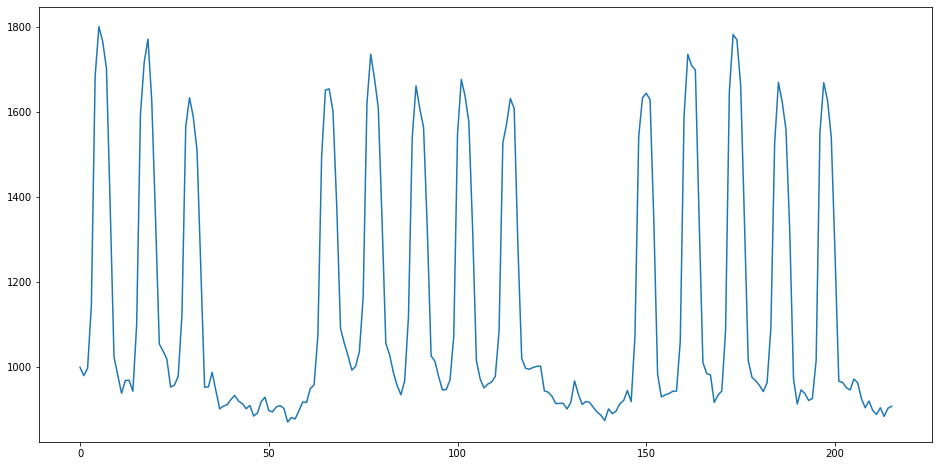

In [141]:
plt.plot(mean_x[1092:1308])
plt.show()

Ora vengono selezionate le porzioni di dataset necessarie all'allenamento del modello predittivo. La scelta di queste è stata fatta dopo una ricerca manuale di insiemi di dati privi di anomalie al loro interno; questo particolare, infatti, risulta cruciale per un buon funzionamento del modello predittivo riguardo il nostro obiettivo.

In [142]:
train = []
train.append(mean_x[60 : 1008])
train.append(mean_x[1704: 3204])
train.append(mean_x[3324: 4284])

Viene fatta una ricerca anche per i dati che verranno utilizzati come test per valutare il comportamento del modello predittivo. In questo caso si salvano gli indici del primo dato utile per la predizione di un certo giorno, ovvero il primo valore di consumo del primo giorno della settimana precedente al giorno in questione.
Il primo array contiene gli indici di alcune anomalie (identificate manualmente accertandosi che il valore da predirre fosse
anomalo e che, invece, la settimana precedente fosse completamente priva di anomalie), mentre il secondo contiene degli indici di giornate casuali dal comportamento nominali, le quali, tuttavia, non sono contenute nell'insieme dei dati usati per allenare il modello.

In [143]:
in_anomalies = [1572, 1344, 948]
in_othertest = [1128, 1140, 1152, 1164, 1176, 1188, 1200]

### Fase di train
In questa fase viene effettivamente creato il train set (dataset usato per allenare il modello predittivo). I valori relativi ai consumi registrati vengono normalizzati su una distribuzione uniforme nel range [0, 1]. Sul dataset prodotto la distanza temporale tra un dato e il successivo è di 1 giorno (12 valori sul dataset inziale).

In [144]:
max_power = max(mean_x)
min_power = min(mean_x)
delta_power = max_power - min_power
norm_x = []

norm_x.append([])
for record in train[0]:
    norm_x[-1].append((record-min_power)/delta_power)
norm_x.append([])
for record in train[1]:
    norm_x[-1].append((record-min_power)/delta_power)

temp = []
y = []
for h in range(len(norm_x)):
    ind = 0
    while ind < len(norm_x[h])-12*8:
        new_row = []
        for i in range(12*7):
            new_row.append(norm_x[h][i+ind])
        temp.append(new_row)
        new_row = []
        for i in range(12):
            new_row.append(norm_x[h][ind+i+12*7])
        y.append(new_row)
        ind += 12

X_train = pd.DataFrame(temp)
y_train = pd.DataFrame(y)
X_train

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.272988,0.280494,0.287309,0.404642,0.790222,0.929185,0.924840,0.872494,0.680198,0.436543,...,0.250074,0.256198,0.262716,0.294716,0.253926,0.267457,0.275160,0.287605,0.267556,0.259556
1,0.350025,0.326222,0.364938,0.477235,0.896099,0.934025,0.904296,0.866469,0.605136,0.351407,...,0.279407,0.359111,0.796840,0.941630,0.916642,0.865481,0.610864,0.353580,0.291556,0.283160
2,0.283160,0.287407,0.290173,0.387457,0.822617,0.886321,0.850568,0.814617,0.639407,0.362765,...,0.278025,0.409086,0.851062,0.891852,0.861333,0.820840,0.581037,0.361284,0.318025,0.293432
3,0.272395,0.284247,0.295901,0.416099,0.852247,0.954667,0.976691,0.939457,0.653827,0.438914,...,0.273481,0.371160,0.831802,0.943901,0.876543,0.858272,0.640099,0.412840,0.332346,0.337284
4,0.323556,0.305481,0.296691,0.408099,0.831704,0.896889,0.921185,0.846321,0.591802,0.354568,...,0.281284,0.402469,0.858864,0.939654,0.899753,0.860247,0.602370,0.369284,0.336296,0.305975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.234864,0.265778,0.284148,0.386765,0.742025,0.797235,0.662716,0.697778,0.502222,0.309630,...,0.230025,0.362765,0.712099,0.752198,0.789333,0.774617,0.579852,0.356840,0.290963,0.280889
184,0.297580,0.265086,0.263704,0.271407,0.276938,0.274469,0.266272,0.270420,0.263407,0.231012,...,0.245037,0.340543,0.786074,0.859951,0.788741,0.703407,0.436642,0.308938,0.283852,0.262222
185,0.197235,0.196938,0.200198,0.183605,0.187457,0.187160,0.192691,0.178568,0.171457,0.177481,...,0.200593,0.148346,0.239111,0.208988,0.215605,0.163654,0.200395,0.196148,0.193679,0.198025
186,0.187259,0.196444,0.248691,0.262123,0.697877,0.727704,0.793086,0.762272,0.558914,0.369284,...,0.159012,0.178667,0.205728,0.174222,0.175605,0.176099,0.168296,0.176099,0.194667,0.187556


Si procede ora con l'allenamento dei 10 modelli MLP. Essi vengono allenati con insiemi di dati leggermente diversi gli uni dagli altri (altrimenti avrebbero tutti il medesimo comportamento). Nello specifico il volume di dati che effettivamente viene usato per allenare i singoli modelli è pari al 80% del train set iniziale.
Tutte le reti neurali utilizzate sono composte al loro interno da 3 layer composti a loro volta da 40 neuroni ognuno, la funzione di attivazione utilizzata su questi neuroni è la tangente iperbolica e il valore massimo di iterazioni eseguibili è impostato a 1000.

In [145]:
in_line = []
for i in X_train.index.values:
    in_line.append(i)
regressors = []
for i in range(10):
    random.shuffle(in_line)
    Xi_train = []
    yi_train = []
    for line in range(int(len(in_line)*0.8)):
        Xi_train.append(X_train.loc[in_line[line]])
        yi_train.append(y_train.loc[in_line[line]])
    model = neural_network.MLPRegressor(hidden_layer_sizes = (40, 40, 40), activation = 'tanh', max_iter = 1000).fit(Xi_train, yi_train)
    regressors.append(model)

### Fase di test
Il medesimo procedimento per la composizione del train set viene eseguito per la realizzazione del test set, anch'esso normalizzando i dati come fatto in precedenza.
Per come è realizzato il codice, il test set avrà come primi 3 dati delle anomalie mentre tutti i dati successivi saranno giorni con un comportamento nominale.

In [146]:
X_test = []
y_test = []

test = in_anomalies+in_othertest
for ind in test:
    new_row = []
    for i in range(ind, ind+7*12):
        new_row.append((mean_x[i]-min_power)/delta_power)
    X_test.append(new_row)
    new_row = []
    for i in range(ind+7*12, ind+8*12):
        new_row.append((mean_x[i]-min_power)/delta_power)
    y_test.append(new_row)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

Ora si vanno a registrare i valori predetti dai modelli allenati in precedenza sui dati del test set. Essi sono ottenuti eseguendo una tecnica di ensembling (in questo caso si utilizza la media aritmetica) tra i 10 risultati riguardanti il medesimo input.

In [147]:
predicted = []
for i in range(10):
    prediction = regressors[i].predict(X_test)
    predicted.append(prediction)

predicted_mean = []
for i in range(len(y_test)):
    prediction = []
    for j in range(12):
        prediction.append(0)
    for j in range(10):
        for h in range(12):
            prediction[h] += predicted[j][i][h]/10
    predicted_mean.append(prediction)
predicted = pd.DataFrame(predicted_mean)
predicted

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.203687,0.226083,0.218749,0.296142,0.570065,0.653120,0.627350,0.618878,0.464037,0.266039,0.293423,0.260508
1,0.267960,0.244604,0.305747,0.344504,0.688703,0.778998,0.736659,0.743949,0.507444,0.308985,0.268344,0.280370
2,0.259616,0.251974,0.240510,0.356101,0.603105,0.694146,0.677497,0.636408,0.465670,0.299521,0.286155,0.227350
3,0.260680,0.264489,0.208594,0.238989,0.273212,0.275858,0.215022,0.217389,0.188170,0.213135,0.196841,0.220533
4,0.244760,0.241811,0.190323,0.227426,0.269658,0.264442,0.239616,0.269893,0.236313,0.236987,0.214897,0.244552
5,0.213108,0.227882,0.228477,0.312182,0.603412,0.710316,0.695843,0.668643,0.510348,0.293720,0.306763,0.275400
6,0.257546,0.242884,0.271778,0.365170,0.732512,0.823553,0.832532,0.790339,0.581104,0.320437,0.291421,0.261297
7,0.284593,0.257484,0.318572,0.361709,0.690483,0.764222,0.727421,0.725565,0.513030,0.324083,0.286753,0.280926
8,0.272043,0.273905,0.257582,0.352137,0.725472,0.800040,0.792061,0.761350,0.549465,0.293670,0.276140,0.265720
9,0.258129,0.251317,0.232862,0.334507,0.587436,0.683253,0.648562,0.627193,0.458516,0.286640,0.255260,0.221482


Di seguito vengono stampati i risultati ottenuti sul test set mettendo a confronto i valori predetti con i valori reali.

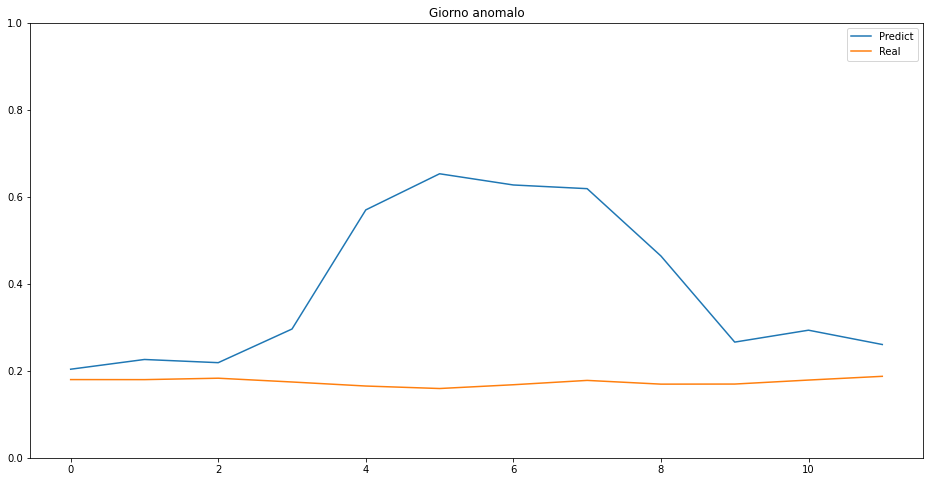

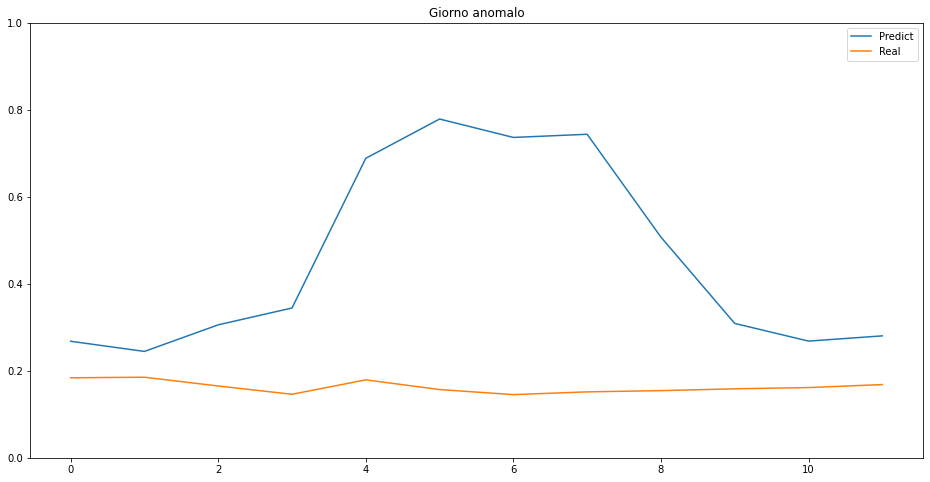

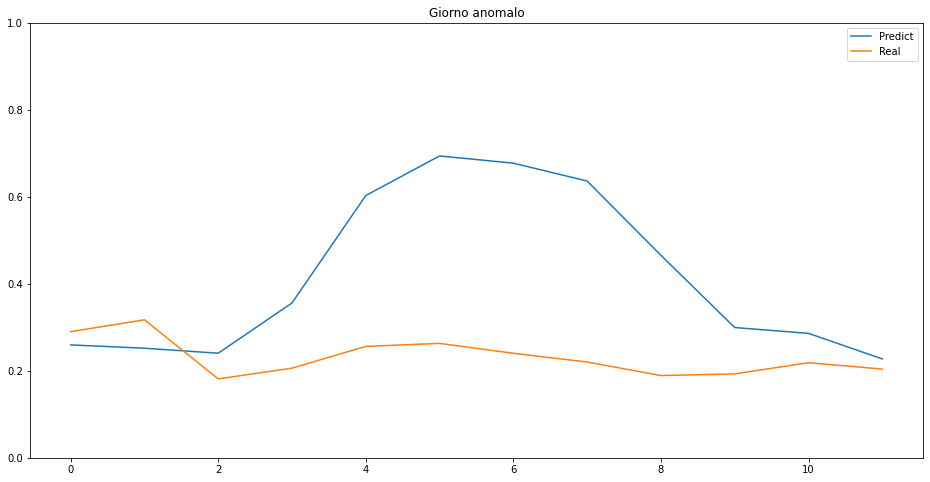

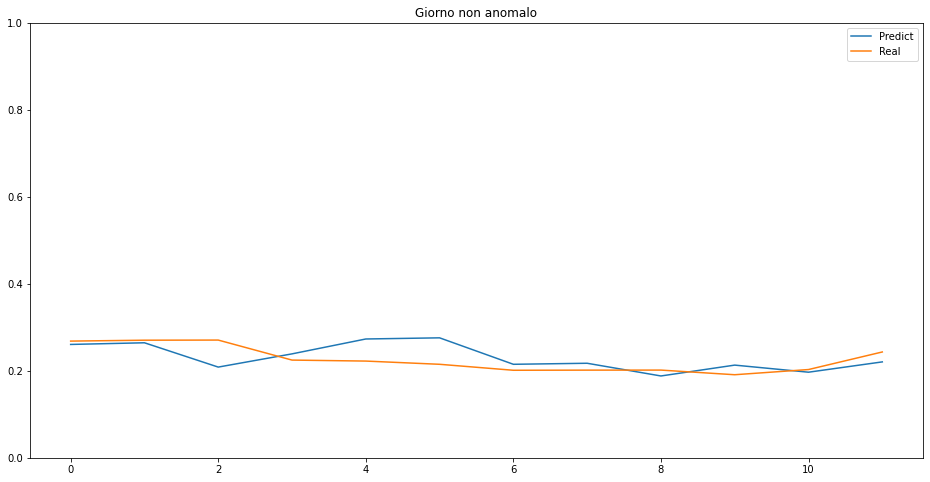

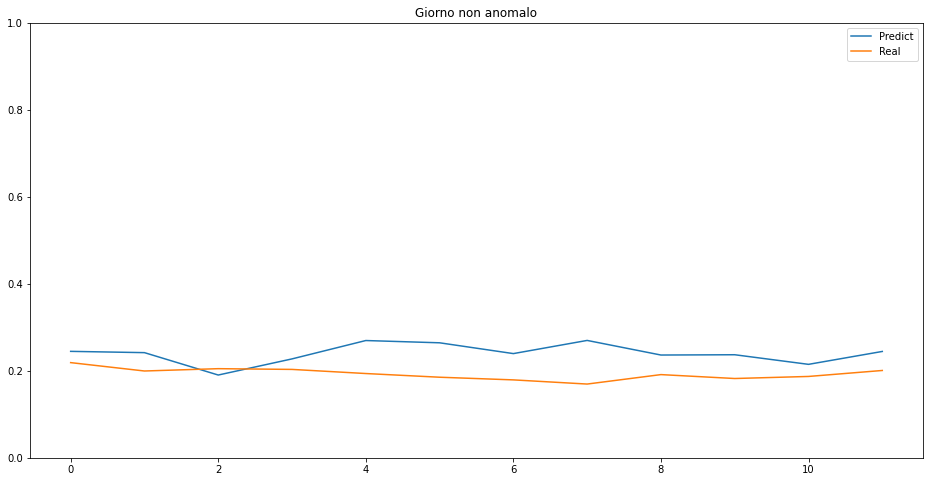

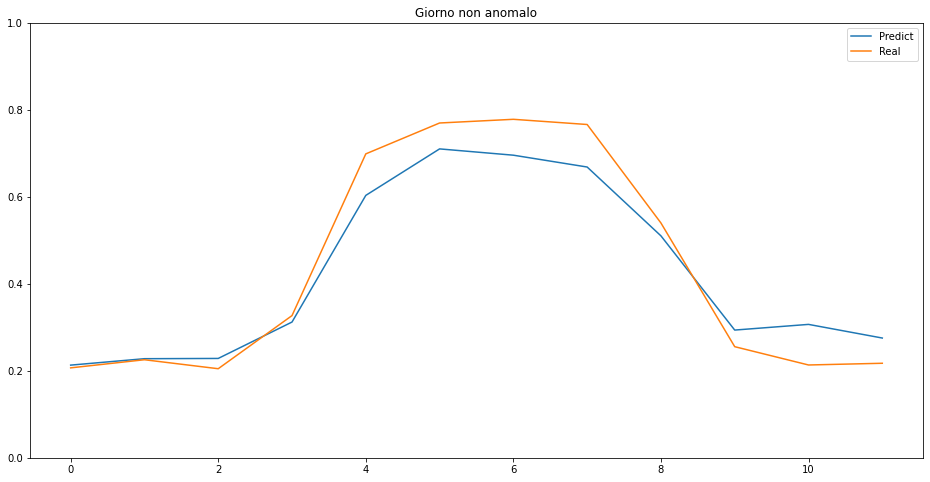

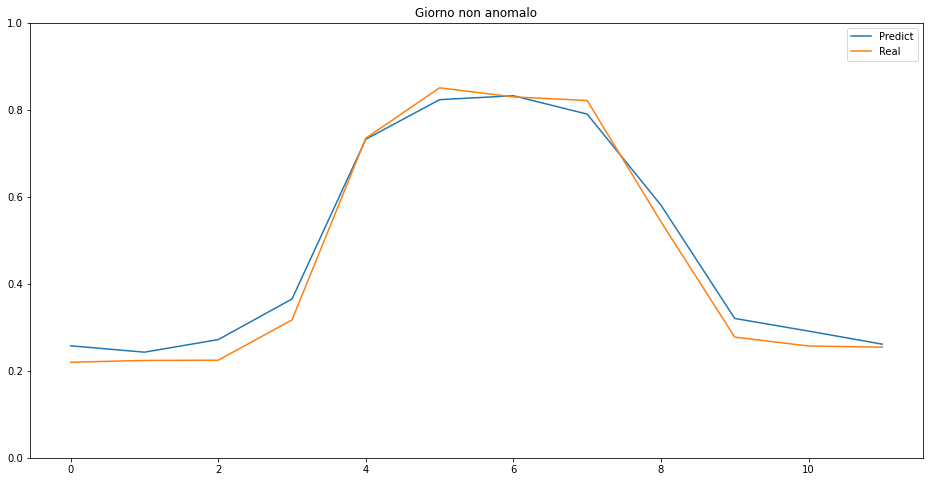

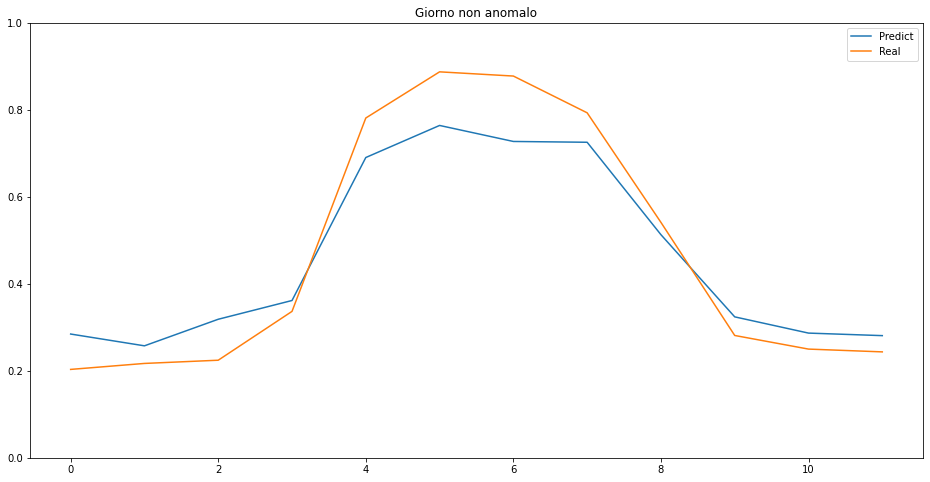

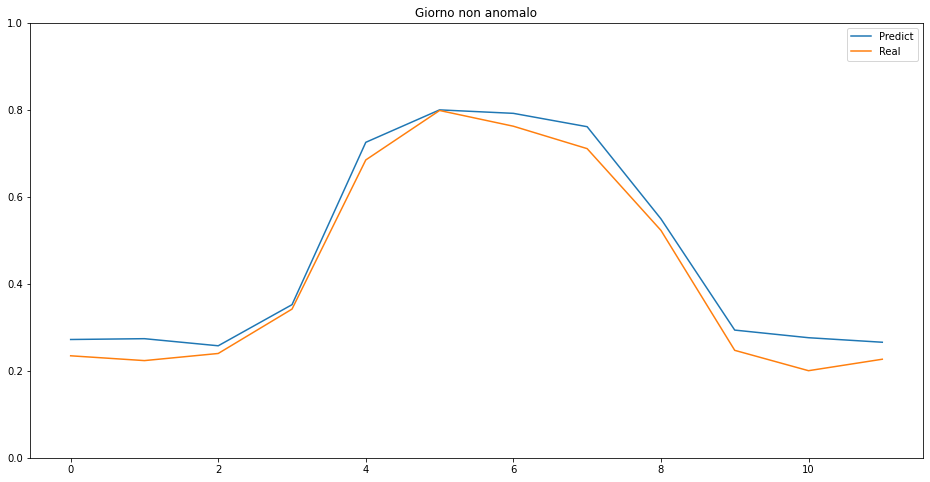

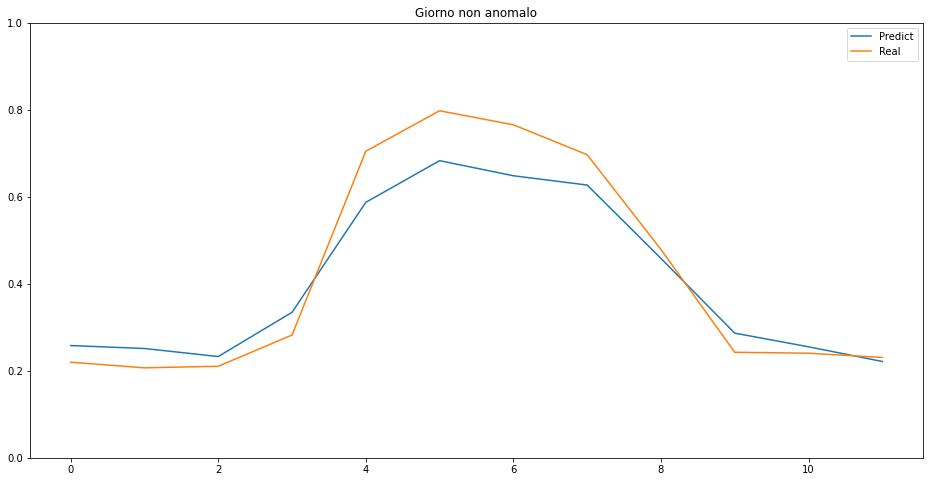

In [148]:
for i, sample in predicted.iterrows():
    title = ""
    if i < 3:
        title = "Giorno anomalo"
    else:
        title = "Giorno non anomalo"
    plt.plot(predicted.columns, predicted.loc[i], label='Predict')
    plt.plot(y_test.columns, y_test.loc[i], label='Real')
    plt.ylim((0,1))
    plt.title(title)
    plt.legend()
    plt.show()

I risultati ottenuti sono positivi dal momento che si nota una buona ricostruzione dei giorni non anomali, il trend di questi infatti viene riconosciuto sia nel caso di giorni lavorativi (dal lunedì al venerdì) sia nel caso di giorni festivi (durante il fine settimana). Per quel che riguarda i giorni anomali, il modello si comporta bene dato che riconosce i consumi tipici di un giorno lavorativo, facendo riferimento ai primi 3 test stampati in precedenza, quando i consumi reali invece hanno un trend attribuibile a una giornata non lavorativa. In questo modo la somma delle differenze tra i valori predetti e i valori reali genera un errore significativo con il quale si è grado di identificare i giorni anomali. Visti i risultati ottenuti è presumibile che il metodo utilizzato sia efficace anche nella identificazione di giorni anomali con consumi bassi nel trend usuale ma che nella realtà presentano consumi attribuibili a giorni lavorativi.

## ANN+Ensembling
In questo programma viene eseguita anomaly detection su un dataset di consumi elettrici riguardanti un'ufficio italiano; nello specifico le anomalie vengono identificate nei giorni in cui i consumi sono significativamente diversi dal trend usuale.
Il modello predittivo utilizzato in questo caso è una combinazione di 10 reti neurali MLP, aventi medesima struttura, le quali vengo allenate con insiemi di dati leggermente diversi tra di loro. Successivamente, al momento della predizione, i risultati delle singole reti vengono combinati insieme usando un metodo di ensembling portando in output del modello la predizione definitiva.

Come input per il modello predittivo si prende il campionamento dei consumi elettrici eseguito ogni 2 ore per un'intera settimana (7 giorni consecutivi) mentre come output si hanno i consumi, campionati ogni 2 ore anch'essi, della giornata successiva alla settimana presa in input.

In [149]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import holidays
import datetime
import sklearn
from sklearn import neural_network
from sklearn import model_selection
import random
# %matplotlib notebook

In [150]:
data = pd.read_pickle('train1.pkl')
data = data.drop(data.columns[[0,4]], axis=1)
en = []
for i in range(len(data)):
    en.append(i)
data['indice'] = en
data.set_index('indice', inplace = True)
data

,AvgT,AvgH,AvgP2,DateTime,holidays,dayofweek
indice,,,,,,
0,4.30,94.199997,34.0,2017-02-08 00:00:00,0,2
1,4.80,94.550003,0.0,2017-02-08 00:15:00,0,2
2,5.40,94.800003,51.0,2017-02-08 00:30:00,0,2
3,5.40,94.449997,0.0,2017-02-08 00:45:00,0,2
4,5.50,94.199997,0.0,2017-02-08 01:00:00,0,2
...,...,...,...,...,...,...
75931,10.95,83.250000,41.0,2019-04-09 22:45:00,0,1
75932,10.80,84.599998,42.0,2019-04-09 23:00:00,0,1
75933,10.65,86.050003,43.0,2019-04-09 23:15:00,0,1


Viene eseguita della pulizia dei dati, rimuovendo le prime giornate registrate a causa di un campionamento incompleto e rimuovendo i dati duplicati nel caso ci siano più di un valore a una determinata data e a un determinato orario.

In [151]:
toremove = []

for ind, sample in data.iterrows():
    if sample['DateTime'] < datetime.datetime(2017, 2, 8):
        toremove.append(ind)
    elif sample['AvgP2'] == 0:
        toremove.append(ind)

data.drop(toremove, inplace = True)
data.sort_index(inplace = True)
data.drop_duplicates(subset = 'DateTime', keep = 'first', inplace = True)

Avviene ora una scomposizione del dato Data-Ora in più attributi. Dal momento che l'obiettivo è avere un campionamento con frequenza di 1 campione ogni 2 ore, il valore rappresentante l'ora della giornata viene diviso per 2 trascurando il possibile resto prodotto (divisione naturale).

In [152]:
dat = {'Power':[], 'Year':[], 'Month':[], 'Day':[],
       'Hour':[], 'Minutes':[], 'holidays':[], 'dayofweek':[]}

for ind, sample in data.iterrows():
    dat['Year'].append(sample['DateTime'].year)
    dat['Month'].append(sample['DateTime'].month)
    dat['Day'].append(sample['DateTime'].day)
    dat['Hour'].append(sample['DateTime'].hour//2)
    dat['Minutes'].append(sample['DateTime'].minute)
    dat['Power'].append(sample['AvgP2'])
    dat['holidays'].append(sample['holidays'])
    dat['dayofweek'].append(sample['dayofweek'])

In [153]:
data = pd.DataFrame.from_dict(dat)
data

,Power,Year,Month,Day,Hour,Minutes,holidays,dayofweek
0,34.0,2017,2,8,0,0,0,2
1,51.0,2017,2,8,0,30,0,2
2,52.0,2017,2,8,0,45,0,2
3,42.0,2017,2,8,1,15,0,2
4,51.0,2017,2,8,1,0,0,2
...,...,...,...,...,...,...,...,...
75518,41.0,2019,4,9,11,45,0,1
75519,42.0,2019,4,9,11,0,0,1
75520,43.0,2019,4,9,11,15,0,1
75521,42.0,2019,4,9,11,30,0,1


Avviene una riduzione del volume dei dati: 1 record ogni 2 ore. Vengono inoltre eliminate le colonne relative ai minuti, giorno della settimana e vacanze.

In [154]:
data.drop(['Minutes', 'holidays', 'dayofweek'], axis = 1, inplace = True)
data = data.groupby(['Year', 'Month', 'Day', 'Hour']).mean().reset_index()
data

,Year,Month,Day,Hour,Power
0,2017,2,8,0,45.666667
1,2017,2,8,1,46.500000
2,2017,2,8,2,53.500000
3,2017,2,8,3,57.000000
4,2017,2,8,4,89.000000
...,...,...,...,...,...
9453,2019,4,9,7,81.625000
9454,2019,4,9,8,64.875000
9455,2019,4,9,9,60.875000
9456,2019,4,9,10,46.500000


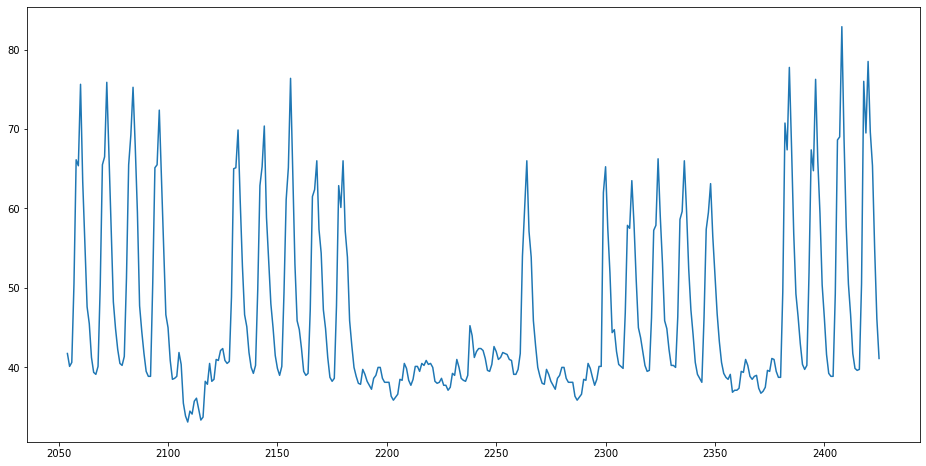

In [155]:
#mese di test: agosto 2017
d = data.loc[(data['Month'] == 8) & (data['Year'] == 2017)]
plt.plot(d['Power'])
plt.show()

Come train set vengono presi i dati relativi ai mesi di luglio, settembre e ottobre 2017 data la loro omegeneità a livello di valori dei consumi e per l'assenza di giornate anomale. Dopo un'analisi del dataset nel suo complesso si è infatti notato che, seppur i trend rimangono costanti, i valori effettivi dei consumi variano significativamente tra diverse stagioni. Questo porta a una maggiore difficoltà da parte del modello nel compiere predizioni corrette. Di conseguenza, per questa sperimentazione si è voluto trattare solo dati inerenti alla stagionalità estiva.

In [156]:
train = []
train.append(data.loc[(data['Month'] == 7) & (data['Year'] == 2017)]['Power'])
train.append(data.loc[((data['Month'] == 9) | (data['Month'] == 10)) & (data['Year'] == 2017)]['Power'])

Come test set vengono prese le giornate relative alla prima metà di agosto 2017 (le giornate per cui si andrà a fare la predizione saranno dal 8 al 14 agosto). Tra queste è presente una anomalia: il 14 agosto è infatti un lunedì con consumi molto bassi rispetto al trend usuale.

In [157]:
test = data.loc[(data['Month'] == 8) & (data['Year'] == 2017)].reset_index()
test = test.drop(test.loc[test['Day'] > 14].index)

### Fase di train
In questa fase viene effettivamente creato il train set (dataset usato per allenare il modello predittivo). I valori relativi ai consumi registrati vengono normalizzati su una distribuzione uniforme nel range [0, 1]. Sul dataset prodotto la distanza temporale tra un dato e il successivo è di 1 giorno (12 valori sul dataset inziale).

In [158]:
max_power = 0
min_power = 100000
for serie in train:
    max_power = max(max_power, max(serie))
    min_power = min(min_power, min(serie))
max_power = max(max_power, max(test['Power']))
min_power = min(min_power, min(test['Power']))

delta_power = max_power - min_power
norm_x = []

norm_x.append([])
for record in train[0]:
    norm_x[-1].append((record-min_power)/delta_power)
norm_x.append([])
for record in train[1]:
    norm_x[-1].append((record-min_power)/delta_power)

temp = []
y = []
for h in range(len(norm_x)):
    ind = 0
    while ind <= len(norm_x[h])-12*8:
        new_row = []
        for i in range(12*7):
            new_row.append(norm_x[h][i+ind])
        temp.append(new_row)
        new_row = []
        for i in range(12):
            new_row.append(norm_x[h][ind+i+12*7])
        y.append(new_row)
        ind += 12

X_train = pd.DataFrame(temp)
y_train = pd.DataFrame(y)
X_train

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.138158,0.131579,0.144737,0.186404,0.201754,0.201754,0.138158,0.122807,0.157895,0.171053,...,0.125000,0.311404,0.640351,0.679825,0.760965,0.679825,0.412281,0.269737,0.208333,0.182018
1,0.151316,0.140351,0.142544,0.125000,0.118421,0.100877,0.100877,0.100877,0.149123,0.151316,...,0.140351,0.206140,0.263158,0.252193,0.116228,0.114035,0.144737,0.140351,0.168860,0.182018
2,0.149123,0.138158,0.146930,0.315789,0.646930,0.675439,0.831140,0.703947,0.484649,0.274123,...,0.127193,0.118421,0.098684,0.087719,0.087719,0.103070,0.144737,0.155702,0.182018,0.171053
3,0.151316,0.144737,0.144737,0.342105,0.644737,0.695175,0.822368,0.739035,0.515351,0.315789,...,0.133772,0.344298,0.690789,0.686404,0.800439,0.697368,0.486842,0.432957,0.179825,0.635965
4,0.135965,0.127193,0.122807,0.335526,0.662281,0.728070,0.844298,0.712719,0.515351,0.359649,...,0.692982,0.548246,0.396930,0.206140,0.177632,0.146930,0.140351,0.140351,0.320175,0.657895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.059211,0.043860,0.048246,0.219298,0.760965,0.778509,0.914474,0.741228,0.524123,0.388158,...,0.061404,0.236842,0.699561,0.690789,0.817982,0.725877,0.592105,0.390351,0.206140,0.109649
73,0.072368,0.057018,0.054825,0.118421,0.276316,0.217105,0.230263,0.182018,0.105263,0.107456,...,0.074561,0.298246,0.842105,0.708333,0.831140,0.760965,0.605263,0.346491,0.199561,0.100877
74,0.065789,0.048246,0.041667,0.046053,0.035088,0.015351,0.015351,0.030702,0.070175,0.087719,...,0.072368,0.223684,0.265351,0.239035,0.103070,0.061404,0.107456,0.129386,0.129386,0.114035
75,0.043860,0.041667,0.041667,0.221491,0.657895,0.616228,0.857456,0.774123,0.576754,0.379386,...,0.072368,0.074561,0.059211,0.052632,0.070175,0.065789,0.129386,0.138158,0.129386,0.105263


Si procede ora con l'allenamento dei 10 modelli MLP. Essi vengono allenati con insiemi di dati leggermente diversi gli uni dagli altri (altrimenti avrebbero tutti il medesimo comportamento). Nello specifico il volume di dati che effettivamente viene usato per allenare i singoli modelli è pari al 80% del train set iniziale.
Tutte le reti neurali utilizzate sono composte al loro interno da 3 layer composti a loro volta da 40 neuroni ognuno, la funzione di attivazione utilizzata su questi neuroni è la tangente iperbolica e il valore massimo di iterazioni eseguibili è impostato a 1000.

In [159]:
in_line = []
for i in X_train.index.values:
    in_line.append(i)
regressors = []
for i in range(10):
    random.shuffle(in_line)
    Xi_train = []
    yi_train = []
    for line in range(int(len(in_line)*0.8)):
        Xi_train.append(X_train.loc[in_line[line]])
        yi_train.append(y_train.loc[in_line[line]])
    model = neural_network.MLPRegressor(hidden_layer_sizes = (40, 40, 40), activation = 'tanh', max_iter = 1000).fit(Xi_train, yi_train)
    regressors.append(model)

### Fase di test
Il medesimo procedimento per la composizione del train set viene eseguito per la realizzazione del test set, anch'esso normalizzando i dati come fatto in precedenza.

In [160]:
X_test = []
y_test = []

ind = 0
while ind<=len(test.index)-8*12:
    new_row = []
    for i in range(ind, ind+7*12):
        new_row.append((test.iloc[i]['Power']-min_power)/delta_power)
    X_test.append(new_row)
    new_row = []
    for i in range(ind+7*12, ind+8*12):
        new_row.append((test.iloc[i]['Power']-min_power)/delta_power)
    y_test.append(new_row)
    ind += 12
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
y_test

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.144737,0.131579,0.149123,0.315789,0.546053,0.587719,0.677632,0.475877,0.381579,0.285088,0.232456,0.171053
1,0.142544,0.127193,0.146930,0.309211,0.515351,0.585526,0.782895,0.574561,0.372807,0.247807,0.228070,0.186404
2,0.135965,0.127193,0.131579,0.271930,0.521930,0.537281,0.600877,0.449561,0.396930,0.271930,0.230263,0.166667
3,0.122807,0.114035,0.120614,0.280702,0.546053,0.497807,0.600877,0.445175,0.388158,0.247807,0.192982,0.144737
4,0.125000,0.109649,0.107456,0.140351,0.129386,0.114035,0.105263,0.096491,0.120614,0.127193,0.144737,0.144737
5,0.120614,0.111842,0.111842,0.111842,0.081140,0.072368,0.078947,0.085526,0.118421,0.116228,0.153509,0.142544
6,0.116228,0.105263,0.118421,0.146930,0.146930,0.135965,0.153509,0.149123,0.160088,0.151316,0.153509,0.144737


Ora si vanno a registrare i valori predetti dai modelli allenati in precedenza sui dati del test set. Essi sono ottenuti eseguendo una tecnica di ensembling (in questo caso si utilizza la media aritmetica) tra i vari risultati riguardanti il medesimo input.

In [161]:
predicted = []
for i in range(10):
    prediction = regressors[i].predict(X_test)
    predicted.append(prediction)
predicted_mean = []
for i in range(len(y_test)):
    prediction = []
    for j in range(12):
        prediction.append(0)
    for j in range(10):
        for h in range(12):
            prediction[h] += predicted[j][i][h]/10
    predicted_mean.append(prediction)
predicted = pd.DataFrame(predicted_mean)
predicted

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.190526,0.222651,0.199410,0.290115,0.642176,0.590529,0.744309,0.600885,0.484151,0.346851,0.198268,0.194721
1,0.194483,0.232624,0.213954,0.282253,0.557191,0.549912,0.689864,0.564006,0.476843,0.320131,0.206932,0.229870
2,0.212813,0.218372,0.183633,0.302636,0.651005,0.619991,0.792092,0.671406,0.527640,0.356358,0.205520,0.224606
3,0.159780,0.166721,0.163855,0.277527,0.538070,0.507554,0.624655,0.531711,0.404165,0.259656,0.139801,0.150077
4,0.121428,0.120682,0.115820,0.143838,0.193359,0.173528,0.140022,0.101432,0.099201,0.128102,0.115447,0.156007
5,0.135903,0.153100,0.120735,0.139475,0.200280,0.151888,0.228483,0.170284,0.168658,0.174152,0.153728,0.209643
6,0.175299,0.223687,0.210582,0.269552,0.512198,0.503908,0.629680,0.536048,0.422745,0.304447,0.183715,0.247726


Di seguito vengono stampati i risultati ottenuti sul test set mettendo a confronto i valori predetti con i valori reali.

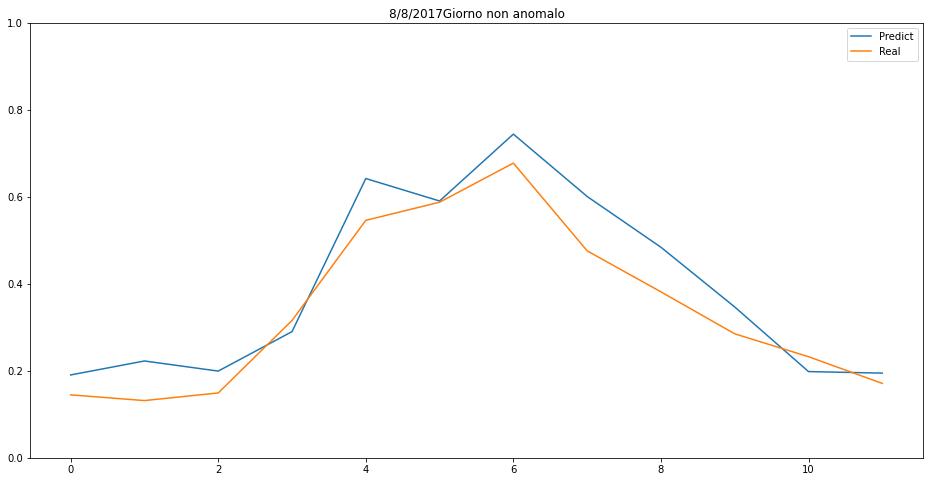

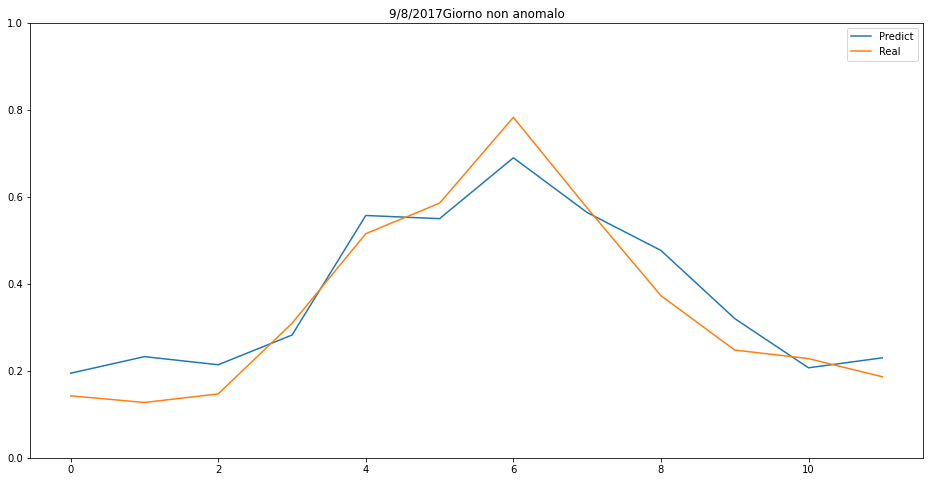

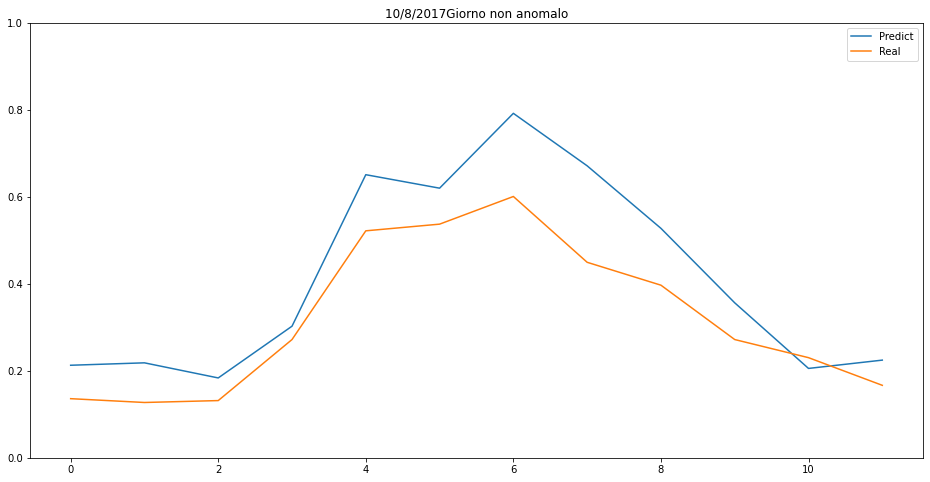

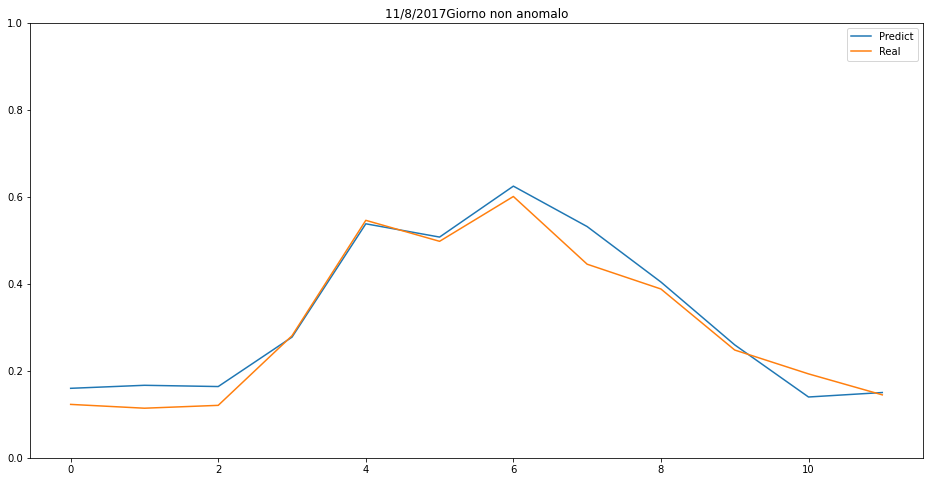

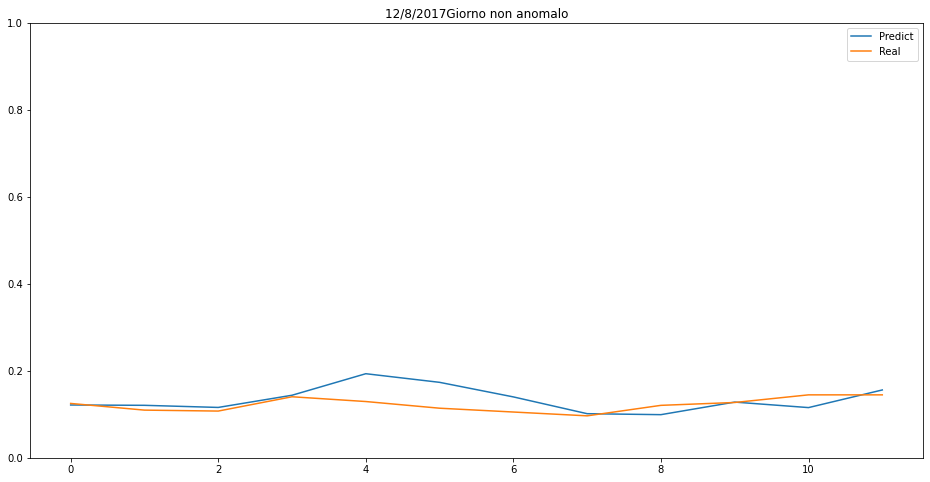

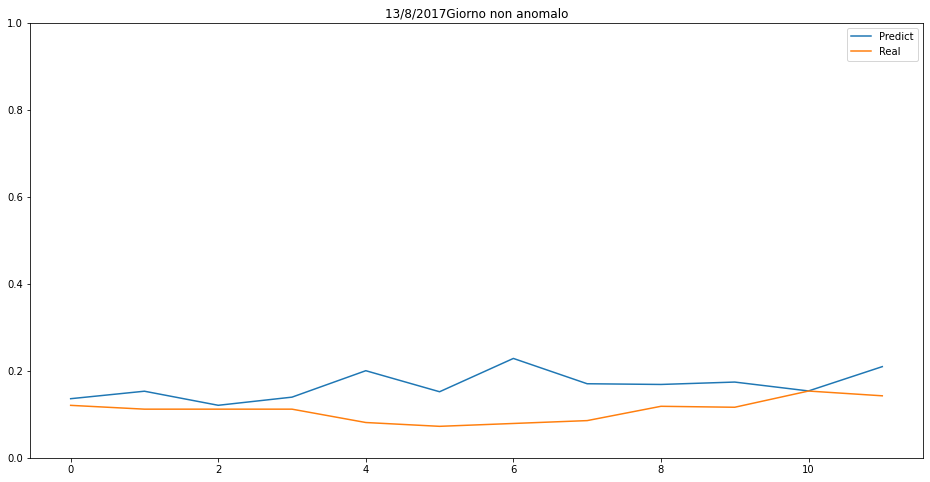

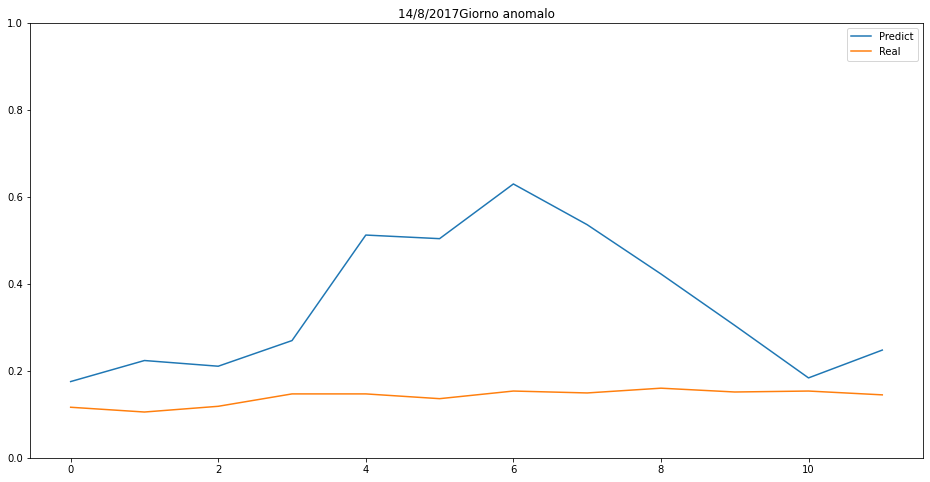

In [162]:
for i, sample in predicted.iterrows():
    title = (str(i+7+1)+"/8/2017")
    if i <= 5:
        title += "Giorno non anomalo"
    else:
        title += "Giorno anomalo"
    plt.plot(predicted.columns, predicted.loc[i], label='Predict')
    plt.plot(y_test.columns, y_test.loc[i], label='Real')
    plt.ylim((0,1))
    plt.legend()
    plt.title(title)
    plt.show()

I risultati ottenuti sono positivi dal momento che si nota una buona ricostruzione dei giorni non anomali, il trend di questi infatti viene riconosciuto sia nel caso di giorni lavorativi (dal lunedì al venerdì) sia nel caso di giorni festivi (durante il fine settimana). Per quel che riguarda i giorni anomali, il modello si comporta bene dato che riconosce i consumi tipici di un giorno lavorativo, facendo riferimento all'ultimo stampato nella precedente sezione, quando i consumi reali invece hanno un trend attribuibile a una giornata non lavorativa. In questo modo la somma delle differenze tra i valori predetti e i valori reali genera un errore significativo con il quale si è grado di identificare i giorni anomali. Visti i risultati ottenuti è presumibile che il metodo utilizzato sia efficace anche nella identificazione di giorni anomali con consumi bassi nel trend usuale ma che nella realtà presentano consumi attribuibili a giorni lavorativi. Infine è importante sottolineare che la qualità dei risultati ottenuti è generata anche dalla scelta fatta a priori di dividere i dati, utilizzati per allenare e testare il modello predittivo, seguendo un criterio stagionale. Da precedenti sperimentazioni si è notato un comportamento negativo da parte del modello nel caso di utilizzo di dati appartenenti a giorni di diverse stagioni. I trend, infatti, sono pressochè costanti durante l'intero anno, tuttavia non si può dire lo stesso per i valori assoluti dei singoli consumi: nel dataset utilizzato essi hanno variazioni troppo significative fra diverse stagioni.

## Long Short Term Memory Networks for Anomaly Detection in Time Series : analisi e implementazione
Questa sezione implementa e analizza "Malhotra, Pankaj & Vig, Lovekesh & Shroff, Gautam & Agarwal, Puneet. (2015). Long Short Term Memory Networks for Anomaly Detection in Time Series.". Questo lavoro propone di usare una LSTM addestrata per prevedere l'andamento del giorno successivo (ponendo come input la sequenza dei 14 giorni precedenti) e di usare la differenza tra la sequenza prevista e quella reale per ottenere un vettore degli errori (vettore dei residui). I vettori dei residui vengono poi usati per calcolare la media e la covarianza per stimare la distribuzione gaussiana multivariata dei dati non anomali. In seguito, viene trovata una soglia per separare i dati anomali da quelli normali massimizzando $F_{0.1}$. Inoltre, diversamente da quanto proposto, se invece di usare la likelihood della distribuzione si usa la norma $L^{p}$ del vettore dei residui è possibile ottenere risultati mediamente migliori. <br>
Il dataset è stato separato nel seguente modo:
* Training: Usato per addestrare la rete neurale (contiene solo dati non anomali)
* Test: Usato per valutare il risultato finale (contiene sia dati anomali che normali)
* Validation 1: Usato per early stop e stima di media e varianza (contiene solo dati non anomali)
* Validation 2: Usato per trovare la soglia ottimale (contiene sia dati anomali che normali)

In [163]:
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import tensorflow.keras.layers as layers
from sklearn.model_selection import KFold
import scipy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, rand
import seaborn as sns
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.preprocessing import QuantileTransformer, quantile_transform, PowerTransformer, power_transform, robust_scale, minmax_scale
from pingouin import multivariate_normality
import gc

### Parametri
In questa sezione definiamo i parametri e le costanti utilizzate.

In [164]:
DAY = 12 # numero di punti per giorno
BATCH_SIZE = 512 # dimensione batch
WINDOW_OFFSET = DAY * 1 # distanza tra x[0] e y[0]
WINDOW_SIZE = DAY * 14 # dimensione della finestra utilizzata
WINDOW_SEEN = DAY * 7 # vengono considerati solo risultati da y[WINDOW_SEEN:]
FIG_SIZE = (16, 10) # dimensione grafici
HYPERTUNE = False # per la ricerca degli iperparametri

### Funzioni Utili

In [165]:
def get_windows(x, win_in=WINDOW_SIZE, win_off=WINDOW_OFFSET, skip=8):
    # Converte una serie di dati in un serie di finestre sovrapposte di dimensione win_in
    x = x[::skip]
    y = np.vstack([x[i+win_off:i+win_in+win_off] for i in range(len(x)-win_in-win_off)])
    x = np.vstack([x[i:i+win_in] for i in range(len(x)-win_in-win_off)])
    x = np.expand_dims(x, axis=-1)
    y = np.expand_dims(y, axis=-1)
    return x, y

In [166]:
def get_model(units=[40, 30], dropout_rate=0.1, inp_noise=0.0, inp_dropout=0.0, loss='mse', recurrent='lstm', lr=1e-2, dense_activation='sigmoid', hidden_unit=1, ensemble=1):
    # Genera un modello in base agli iperparametri passati

    inp = layers.Input(shape=(None, 1))
    x = inp
    base = x

    if recurrent != 'none':
        recurrent_layer = {
            'gru': layers.GRU,
            'lstm': layers.LSTM,
            'rnn': layers.SimpleRNN,
        }[recurrent]
        ans = 0
        x = base
        for i in range(ensemble):
            x = tf.keras.layers.GaussianNoise(inp_noise)(x)
            x = tf.keras.layers.Dropout(inp_dropout)(x)

            for unit in units:
                x = recurrent_layer(unit, return_sequences=True)(x)
                x = layers.Dropout(dropout_rate)(x)
                if dense_activation != 'zero':
                    x = layers.Dense(unit)(x)
                    x = layers.Activation(dense_activation)(x)


            x = layers.Dense(1)(x)
            ans += x
        ans /= ensemble
        x = ans
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(lr)
    loss = {'mse':'mse',
         'mae':'mae',
         'mape': 'mape',
         'robust':tfa.losses.pinball_loss
    }[loss]
    model.compile(opt, loss, metrics=['mse', 'mape', 'mae'])
    return model


In [167]:
def run(x, holidays, params={}, verbose=1, batch_size=BATCH_SIZE, maxpos=WINDOW_SEEN):
    # addestra il modello sui dati in input (x e holidays) e resistituisce i risultati e le metriche ottenute in un dizionario
    # i parametri params vengono usati per generare il modello (tramite get_model)
    if 'rob_cov' in params:
        rob_cov = params['rob_cov']
        del params['rob_cov']
    else:
        rob_cov = False

    x = np.clip(x, np.percentile(x, 5), np.percentile(x, 95))
    x = minmax_scale(x.reshape(-1, 1)).flatten()

    print(len(holidays[holidays == 0]), len(holidays[holidays == 1]))

    x, y = get_windows(x)
    x_cnt = np.arange(len(x))
    x_holidays, y_holidays = get_windows(holidays)
    x_holidays = np.squeeze(x_holidays)
    y_holidays = np.squeeze(y_holidays)

    # split sets
    cond = ((x_holidays == 1).any(-1))|((y_holidays == 1).any(-1))
    x_anom = x[cond]
    x_noanom = x[~cond]
    y_anom = y[cond]
    y_noanom = y[~cond]
    cnt_anom = x_cnt[cond]
    cnt_noanom = x_cnt[~cond]

    good_split = [0.45, 0.625, 0.75]
    anomaly_split = [0.45]
    good_int = [int(len(x_noanom)*a) for a in good_split]
    anomaly_int = [int(len(x_anom)*a) for a in anomaly_split]
    x_train, x_val1, x_val2, x_test = np.split(x_noanom, good_int)
    y_train, y_val1, y_val2, y_test = np.split(y_noanom, good_int)
    cnt_train, cnt_val1, cnt_val2, cnt_test = np.split(cnt_noanom, good_int)

    x_aval2, x_atest = np.split(x_anom, anomaly_int)
    y_aval2, y_atest = np.split(y_anom, anomaly_int)
    cnt_aval2, cnt_atest = np.split(cnt_anom, anomaly_int)

    x_val2 = np.concatenate([x_val2, x_aval2])
    y_val2 = np.concatenate([y_val2, y_aval2])
    cnt_val2 = np.concatenate([cnt_val2, cnt_aval2])

    x_test = np.concatenate([x_test, x_atest])
    y_test = np.concatenate([y_test, y_atest])
    cnt_test = np.concatenate([cnt_test, cnt_atest])

    print('x_train:', x_train.shape)
    print('x_val1:', x_val1.shape)
    print('x_val2:', x_val2.shape)
    print('x_test:', x_test.shape)

    # fit
    model = get_model(**params)
    hist = model.fit(x_train, y_train,
             batch_size=batch_size,
             epochs=1000,
             verbose = verbose,
             validation_data=(x_val1, y_val1),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, verbose=True)
    ]).history

    # postprocess
    def gen_ans(x_curr, y_curr, cnt_curr):
        ans = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        ans_pred = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        ans_curr = [[] for i in range(len(x) + 2*WINDOW_SIZE)]
        y_pred = model.predict(x_curr)

        for off, win_pred, win_curr in zip(cnt_curr, y_pred, y_curr):
            for p0, (val_pred, val_curr) in enumerate(zip(win_pred, win_curr)):
                ans[off + p0].append(val_pred[0] - val_curr[0])
                ans_pred[off + p0].append(val_pred[0])
                ans_curr[off + p0].append(val_curr[0])

        pos = [i for i in range(len(ans)) if len(ans[i]) >= maxpos]
        ans = [v[:maxpos] for v in ans if len(v) >= maxpos]
        ans_pred = [v[:maxpos] for v in ans_pred if len(v) >= maxpos]
        ans_curr = [v[:maxpos] for v in ans_curr if len(v) >= maxpos]

        return np.array(pos), np.array(ans), np.array(ans_pred), np.array(ans_curr)

    pos_train, ans_train, pred_train, curr_train = gen_ans(x_train, y_train, cnt_train)
    pos_val1, ans_val1, pred_val1, curr_val1 = gen_ans(x_val1, y_val1, cnt_val1)
    pos_val2, ans_val2, pred_val2, curr_val2 = gen_ans(x_val2, y_val2, cnt_val2)
    pos_test, ans_test, pred_test, curr_test = gen_ans(x_test, y_test, cnt_test)


    assert len(holidays) // 8 > pos_test.max() + WINDOW_OFFSET, f'{len(holidays) // 8} < {pos_test.max() + WINDOW_OFFSET}'
    assert pos_test.min() >= 0, f'{pos_test.min()} < 0'
    assert len(holidays) // 8 > pos_val2.max() + WINDOW_OFFSET, f'{len(holidays) // 8} < {pos_val2.max() + WINDOW_OFFSET}'
    assert pos_test.min() >= 0, f'{pos_val2.min()} < 0'

    holi_test = holidays[::8][pos_test + WINDOW_OFFSET]
    holi_val2 = holidays[::8][pos_val2 + WINDOW_OFFSET]

    assert holidays[::8][pos_train + WINDOW_OFFSET].sum() == 0
    assert holidays[::8][pos_val1  + WINDOW_OFFSET].sum() == 0
    assert holi_test.sum() > 0
    assert holi_val2.sum() > 0

    print('holi_test:', holi_test.sum())
    print('holi_val2:', holi_test.sum())

    if rob_cov:
        mcd = MinCovDet(support_fraction=0.8).fit(ans_val1)
    else:
        mcd = EmpiricalCovariance().fit(ans_val1)

    mean = mcd.location_
    cov = mcd.covariance_

    ans = {}
    for h in hist:
        ans[h] = min(hist[h])
    ans['mean'] = mean
    ans['cov'] = cov
    ans['res_train'] = ans_train
    ans['res_test'] = ans_test
    ans['res_val1'] = ans_val1
    ans['res_val2'] = ans_val2
    ans['holidays_val2'] = holi_val2
    ans['holidays_test'] = holi_test
    ans['y_train_pred'] = pred_train
    ans['y_test_pred'] = pred_test
    ans['y_val1_pred'] = pred_val1
    ans['y_val2_pred'] = pred_val2
    ans['y_train'] = curr_train
    ans['y_test'] = curr_test
    ans['y_val1'] = curr_val1
    ans['y_val2'] = curr_val2
    ans['cnt_train'] = pos_train
    ans['cnt_test'] = pos_test
    ans['cnt_val1'] = pos_val1
    ans['cnt_val2'] = pos_val2

    return ans

**print_results:** Questa funziona prima converte ogni vettori dei residui in un valore reale (usando la likelihood o la norma $L^{p}$). Successivamente stima il valore threshold tra istanti anomali e non anomali, ovvero il valore che massimizzi la metrica $F_{0.1}$ usando il validation 2. In seguito, valuta la soglia scelta rispetto al test set.

In [168]:
def conv2week(cnts, y_true, y_pred):
    # unisce le previsioni per settimane
    f_valid = False
    for dx in range(7):
        conta = np.zeros(max(cnts))
        holi_score = np.zeros(max(cnts))
        pred_score = np.zeros(max(cnts))
        for cnt, val, p in zip(cnts, y_true, y_pred):
            cnt = (cnt + dx) // 7
            conta[cnt] += 1
            holi_score[cnt] += val
            pred_score[cnt] += p
        week_used = conta > 1
        holi_score = holi_score[week_used] / conta[week_used]
        pred_score = pred_score[week_used] / conta[week_used]
        if len(holi_score[(holi_score>1e-9)&(holi_score<1-1e-9)]) == 0:
            f_valid = True
        if f_valid:
            break

    return (holi_score > 0.5).astype('int8'), pred_score, (pred_score > 0).astype('int8')


def print_results(ans, use_val=True, print_resp=True, distance_metric=2):
    # calcola il threshold e le metriche
    if use_val:
        res_thresh = ans['res_val2']
        holidays_thresh = ans['holidays_val2']
        cnt_thresh = ans['cnt_val2']
    else:
        res_thresh = ans['res_test']
        holidays_thresh = ans['holidays_test']
        cnt_thresh = ans['cnt_test']

    if distance_metric == 'prob':
        prob = scipy.stats.multivariate_normal.pdf(res_thresh, mean=ans['mean'], cov=ans['cov'], allow_singular=True)
        prob[~np.isfinite(prob)] = 1e300
    else:
        prob = np.linalg.norm(res_thresh, axis=1, ord=distance_metric)

    threshold = 0
    threshold_i = -1
    bestf0_1 = 0
    prob_sorted = np.sort(prob.copy())
    best_conf_matrix = -1
    step = len(prob_sorted)
    for i in range(step):
        p = prob_sorted[i]
        y_pred = (prob > p).astype('int8')
        if distance_metric == 'prob':
            y_pred = 1 - y_pred
        y_true, y_prob, y_pred = conv2week(cnt_thresh, holidays_thresh, y_pred)
        f0_1 = metrics.fbeta_score(y_true, y_pred, beta=0.1)
        if bestf0_1 < f0_1:
            bestf0_1 = f0_1
            threshold = p
            threshold_i = i

    if distance_metric == 'prob':
        prob = scipy.stats.multivariate_normal.pdf(ans['res_test'], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
        prob[~np.isfinite(prob)] = 1e300
    else:
        prob = np.linalg.norm(ans['res_test'], axis=1, ord=distance_metric)
    y_pred = (prob > threshold).astype('int8')
    if distance_metric == 'prob':
        y_pred = 1 - y_pred

    y_true, y_prob, y_pred = conv2week(ans['cnt_test'], ans['holidays_test'], y_pred)

    f0_1 = metrics.fbeta_score(y_true, y_pred, beta=0.1)
    acc = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)

    cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred))

    cm.index.name = 'Reale'
    cm.columns.name = 'Previsto'
    resp = {}
    resp['auc'] = auc
    resp['f0.1'] = f0_1
    resp['accuracy'] = acc
    resp['recall'] = recall
    resp['precision'] = precision
    resp['threshold'] = threshold
    resp['cm'] = cm

    if print_resp:
        print(f'threshold: {threshold} ({threshold_i}/{len(prob_sorted)}) - f0.1: {f0_1} - f0.1(validation): {bestf0_1}')
        print({name:resp[name] for name in resp if name not in ['threshold', 'f0.1', 'cm']})
        print()
        print(metrics.classification_report(y_true, y_pred))
        fig, axs = plt.subplots(figsize=(16, 8), ncols=2)

        sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 16}, ax=axs[0])
        prec, recall, _ = metrics.precision_recall_curve(y_true, y_prob)
        pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=axs[1])
        plt.show()

    if not print_resp:
        return resp

In [169]:
def parse_params(params):
    # converte gli iperparametri in parametri per get_model
    params['units'] = []
    params['ensemble'] = int(params['ensemble'])
    for i in range(3):
        if i < params['n_layers']:
            params['units'].append(int(params[f'unit_{i}']))
        del params[f'unit_{i}']
    del params['n_layers']
    del params['batch_size']
    del params['distance_metric']
    del params['maxpos']
    return params

df_x, df_y = [], []
def objective(params):
    # funzione obiettivo per fmin
    global df_y, df_x
    real_params = params.copy()

    batch_size = int(2**params['batch_size'])
    distance_metric = params['distance_metric']
    maxpos = int(params['maxpos'])

    params = parse_params(params)
    ans0 = run(df_x, df_y, params=params, batch_size=batch_size, verbose=0, maxpos=maxpos)
    ans0 = print_results(ans0, print_resp=False, distance_metric=distance_metric)
    if ans0['f0.1'] > 0.3:
        ans1 = run(df_x, df_y, params=params, batch_size=batch_size, verbose=0, maxpos=maxpos)
        ans1 = print_results(ans1, print_resp=False, distance_metric=distance_metric)
    else:
        ans1 = ans0.copy()
    score = -ans0['f0.1']-ans1['f0.1']

    print(real_params, params)
    print(score, ans0, ans1)

    return score

space = {'n_layers':hp.quniform('n_layers', 1, 3, 1),
         'unit_0':hp.quniform('unit_0', 32, 256, 1),
         'unit_1':hp.quniform('unit_1', 32, 128, 1),
         'unit_2':hp.quniform('unit_2', 4, 128, 1),
         'batch_size':hp.uniform('batch_size', 7, 7.1),
         'dropout_rate':hp.uniform('dropout_rate', 0.0, 0.7),
         'hidden_unit': hp.quniform('hidden_unit', 64, 256, 1),
         'inp_noise':hp.uniform('inp_noise', 0.0, 0.7),
         'inp_dropout':hp.uniform('inp_dropout', 0.0, 0.7),
         'ensemble': hp.quniform('ensemble', 1, 5, 1),
         'dense_activation': hp.choice('dense_activation', ['swish']),
         'loss':hp.choice('loss', ['mse']),
         'recurrent':hp.choice('recurrent', ['lstm']),
         'distance_metric': hp.choice('distance_metric', [2]),
         'maxpos': hp.quniform('maxpos', WINDOW_SIZE - 2 * DAY, WINDOW_SIZE - 1 * DAY, 1),
}

### Paesi Bassi
Il dataset è molto omogeneo e regolare. Quindi risulta più semplice per il modello prevedere lo schema settimanale.

In [170]:
df = pd.read_pickle('train2.pkl').astype('int32')
df

,x,holidays
0,950,1
1,939,1
2,943,1
3,971,1
4,1014,1
...,...,...
35035,622,1
35036,614,1
35037,627,1
35038,633,1


Gli iperparametri usati sono stati trovati usando TPE (Tree of Parzen Estimators). <br>
Il modello è composto da stacked LSTM e tra ogni livello di LSTM è presente un fully connected layer seguito da una funzione di attivazione (swish).

In [171]:
if HYPERTUNE:
    df_x, df_y = df['x'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
gc.collect()
best

In [172]:
params = {'dense_activation': 'swish',
          'dropout_rate': 0.2,
          'ensemble': 5,
          'hidden_unit': 160,
          'inp_dropout': 0.3,
          'inp_noise': 0.0,
          'loss': 'mse',
          'recurrent': 'lstm',
          'units': [50]
}


In [173]:
ans = run(df['x'].to_numpy(), df['holidays'].to_numpy(), params=params)

30336 4704
x_train: (1421, 168, 1)
x_val1: (553, 168, 1)
x_val2: (863, 168, 1)
x_test: (1363, 168, 1)
Epoch 1/1000
3/3 [==============================] - 21s 4s/step - loss: 0.1861 - mse: 0.1861 - mape: 8929264.5234 - mae: 0.3114 - val_loss: 0.0764 - val_mse: 0.0764 - val_mape: 1765407.0000 - val_mae: 0.2205
Epoch 2/1000
3/3 [==============================] - 7s 2s/step - loss: 0.1087 - mse: 0.1087 - mape: 15114563.7500 - mae: 0.2485 - val_loss: 0.0805 - val_mse: 0.0805 - val_mape: 1501100.0000 - val_mae: 0.2073

In [174]:
for metric, val_metric in [('mse', 'val_mse'), ('mae', 'val_mae'), ('mape', 'val_mape')]:
    print(f"{metric.rjust(8)}: {str(round(ans[metric], 3)).rjust(8)} - {str(round(ans[val_metric], 3)).rjust(8)}")

     mse:    0.025 -    0.018
     mae:    0.106 -    0.092
    mape: 7091024.0 - 525697.938


#### Analisi della distribuzione del residuo
In questa sezione, si verifica se la distribuzione del residuo (la differenza tra il valore reale e il valore predetto) sia gaussiana.<br>
Possiamo osservare che tutti i test statistici effettuati (Henze-Zirkler, Kolmogorov-Smirnov, D’Agostino-Pearson) concludono che la distribuzione dei residui non sia gaussiana (p-value minore di $10^{-10}$).

In [175]:
# normality test
def avg_pval(x):
    v = [multivariate_normality(np.random.default_rng().choice(x, size=10, axis=0)[:,:20], alpha=.05).pval for _ in range(200)]
    v = [i for i in v if not np.isnan(i)]
    return np.mean(v)

# Henze-Zirkler test
print('ans_train:', multivariate_normality(ans['res_train'][:,:20], alpha=0.5), avg_pval(ans['res_train']))
print('ans_val1:', multivariate_normality(ans['res_val1'][:,:20], alpha=0.5), avg_pval(ans['res_val1']))
print('ans_val2:', multivariate_normality(ans['res_val2'][:,:20], alpha=0.5), avg_pval(ans['res_val2']))
print('ans_test:', multivariate_normality(ans['res_test'][:,:20], alpha=0.5), avg_pval(ans['res_test']))
print()

args = (ans['mean'], ans['cov'], True, int(5e4))
# Kolmogorov-Smirnov test
print('ans_train:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_train'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_val1:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_val1'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_val2:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_val2'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))
print('ans_test:', scipy.stats.kstest(np.random.default_rng().choice(ans['res_test'], size=150, axis=0), scipy.stats.multivariate_normal.cdf, N=10, args=args))

ans_train: HZResults(hz=200.27915494468888, pval=0.0, normal=False) 0.0
ans_val1: HZResults(hz=42.46364648375024, pval=0.0, normal=False) 0.0
ans_val2: HZResults(hz=130.6925688881871, pval=0.0, normal=False) 0.0
ans_test: HZResults(hz=353.5059889832761, pval=0.0, normal=False) 0.0

ans_train: KstestResult(statistic=0.8819686437061673, pvalue=1.521289860142251e-139)
ans_val1: KstestResult(statistic=0.8866517562513059, pvalue=3.331816266977905e-142)
ans_val2: KstestResult(statistic=0.9750525995577208, pvalue=7.15854434596524e-241)
ans_test: KstestResult(statistic=0.9039274856724224, pvalue=5.062955927801499e-153)


In [176]:
# p-value ottenuto con D’Agostino-Pearson test (test effettuato per ogni dimensione)
for idx, (res_train, res_test) in enumerate(zip(ans['res_train'].T, ans['res_test'].T)):
    print(f'{idx} - training set: {scipy.stats.normaltest(res_train).pvalue} test set: {scipy.stats.normaltest(res_test).pvalue}')


0 - training set: 1.6704288957885015e-21 test set: 3.530080760834731e-110
1 - training set: 1.739755348493416e-21 test set: 3.255089023286937e-110
2 - training set: 1.8417586979665812e-21 test set: 2.9769785993025197e-110
3 - training set: 1.9090418474494443e-21 test set: 2.8412501528573175e-110
4 - training set: 1.9837466559312947e-21 test set: 2.825492651671851e-110
5 - training set: 1.9738112953647272e-21 test set: 3.0112156853110154e-110
6 - training set: 1.9098729067402834e-21 test set: 2.4291374794720228e-110
7 - training set: 1.8415090369055542e-21 test set: 2.36622739708438e-110
8 - training set: 1.688496931428498e-21 test set: 2.852455426918535e-110
9 - training set: 1.5779204821095392e-21 test set: 2.846549529379547e-110
10 - training set: 1.5120114695414096e-21 test set: 2.464386312155468e-110
11 - training set: 1.480774476363485e-21 test set: 2.2035884093723468e-110
12 - training set: 1.429412096515185e-21 test set: 2.572236365258084e-110
13 - training set: 1.33671979564986

#### Istogramma dei residui per istante
Nelle celle successive possiamo osservare come si comporta il residuo in diversi istanti di tempo e set. <br>
In particolare, possiamo osservare che i dataset con delle anomalie (val2 e test) abbiano una distribuzione con code molto più lunghe rispetto ai dataset senza anomalie (val1 e training)

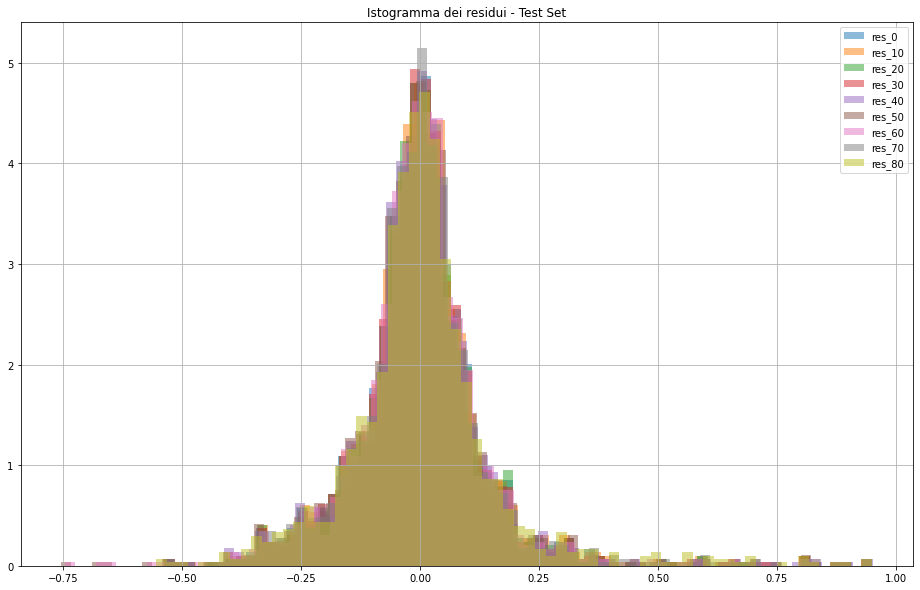

In [177]:
#res plot val1
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_test'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_test']], label=f'res_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Test Set')
ax.grid()
ax.legend()
plt.show()

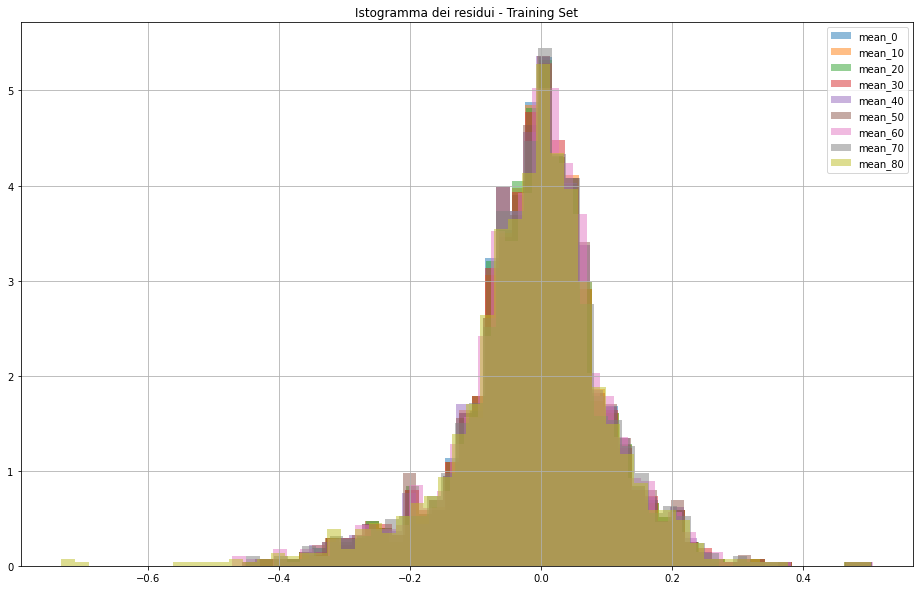

In [178]:
#res plot training
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_train'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_train']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Training Set')
ax.grid()
ax.legend()
plt.show()

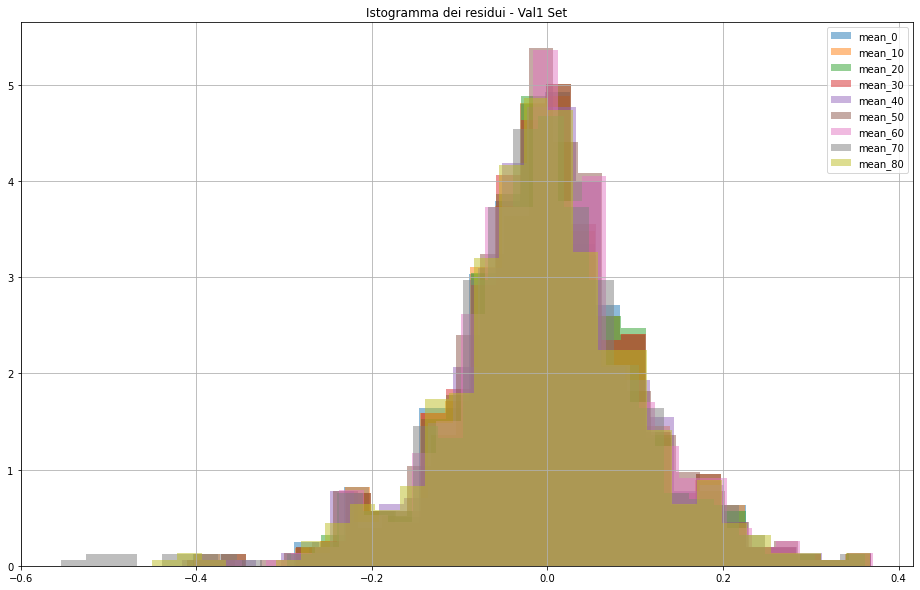

In [179]:
#res plot val1
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_val1'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_val1']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Val1 Set')
ax.grid()
ax.legend()
plt.show()

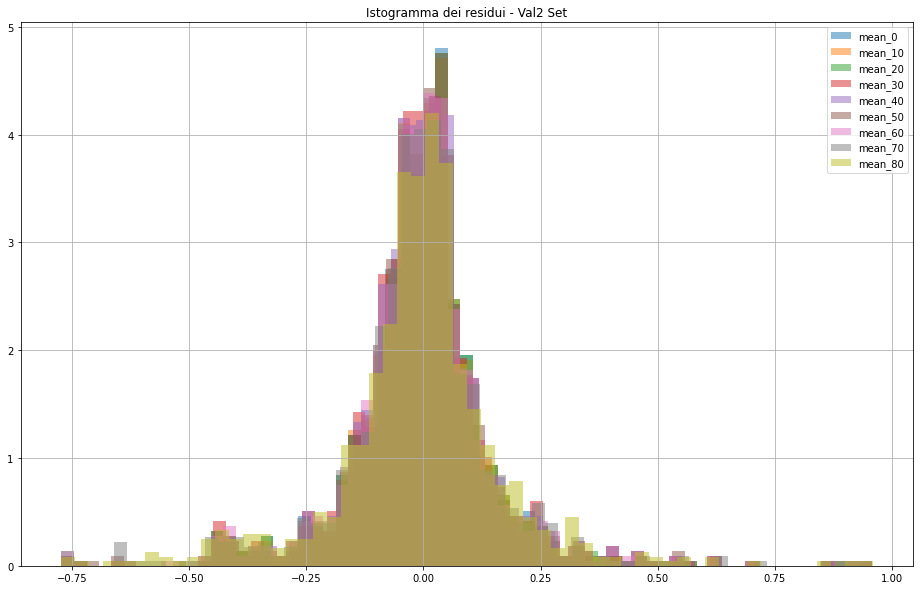

In [180]:
#res plot val2
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
for i in range(0, ans['res_val2'].shape[-1], 10):
    ax.hist([b[i] for b in ans['res_val2']], label=f'mean_{i}', bins='auto', density=True, alpha=0.5)
ax.set_title('Istogramma dei residui - Val2 Set')
ax.grid()
ax.legend()
plt.show()

#### Media e covarianza del residuo

Il valore del residuo per ogni previsione tende ad essere molto vicino a zero

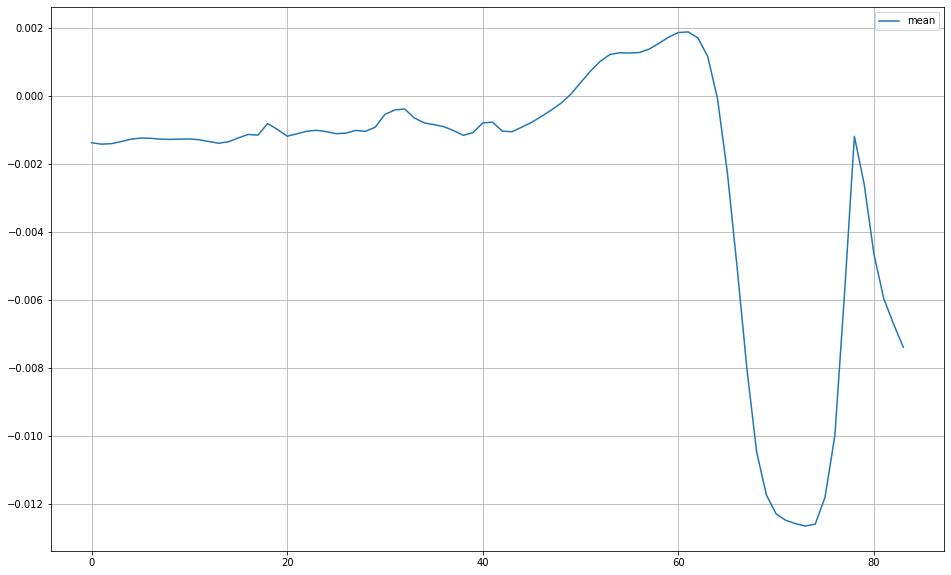

In [181]:
#media rispetto al tempo della previsione
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

Possiamo osservare dalla matrice di covarianza una leggermente maggiore correlazione allineata per ogni giorno. <br>
Inoltre, possiamo anche osservare che il determinante della matrice di covarianza risulta essere molto vicino a zero (essendo tutti gli autovalori strettamente maggiori di zero e molto piccoli). Di conseguenza, essendo la matrice di covarianza quasi singolare, la distribuzione normale multivariata risulta essere degenere.

rank: 84/84
det: 0.0
min(eigvals): 7.085235887374364e-11


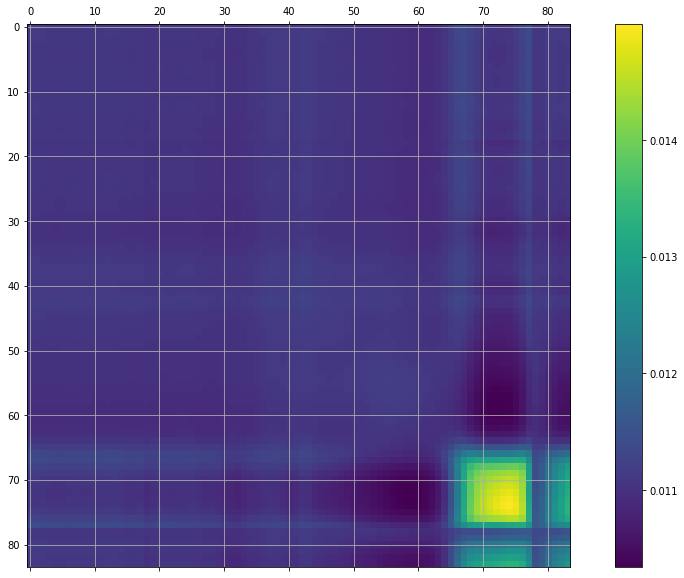

In [182]:
#matrice di covarianza

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])}')
print(f'det: {np.linalg.det(ans["cov"])}')
print(f'min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

#### Confronta tra giorni normali e giorni anomali
La cella sottostante mostra che i residui relativi ai giorni anomali e normali appartengo a due distribuzioni diverse. <br>
Nei grafici sottostanti possiamo osservare come le distribuzioni dei residui siano diverse tra quelle dei giorni normali e quelle dei giorni anomali.

In [183]:
## Kolmogorov-Smirnov statistic on 2 samples
print('test (L2):  ', scipy.stats.ks_2samp(np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2),
                                         np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)))
print('test (prob):', scipy.stats.ks_2samp(scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True),
                                           scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)))
print('val2 (L2):  ', scipy.stats.ks_2samp(np.linalg.norm(ans['res_val2'][ans['holidays_val2'] == 0], axis=1, ord=2),
                                    np.linalg.norm(ans['res_val2'][ans['holidays_val2'] == 1], axis=1, ord=2)))
print('val2 (prob):', scipy.stats.ks_2samp(scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True),
                                           scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)))

test (L2):   KstestResult(statistic=0.14567858248220364, pvalue=0.00011226667725416917)
test (prob): KstestResult(statistic=0.19904828226555246, pvalue=2.305219426457228e-08)
val2 (L2):   KstestResult(statistic=0.11865515436944009, pvalue=0.04305375330493577)
val2 (prob): KstestResult(statistic=0.23992673992673993, pvalue=3.2496143831384217e-07)


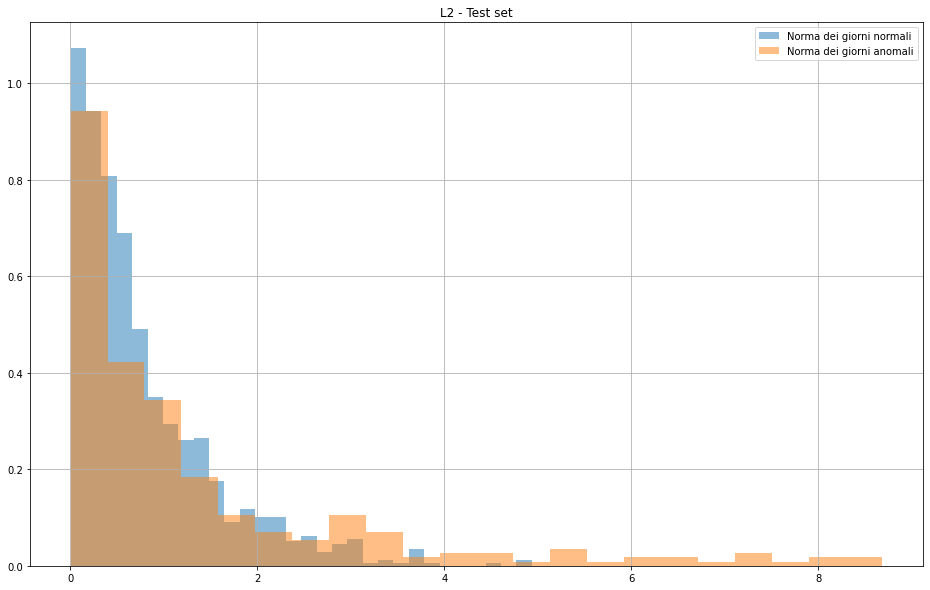

In [184]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2)
prob_holidays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)

ax.hist(prob_normaldays, label='Norma dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(prob_holidays, label='Norma dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('L2 - Test set')
plt.show()

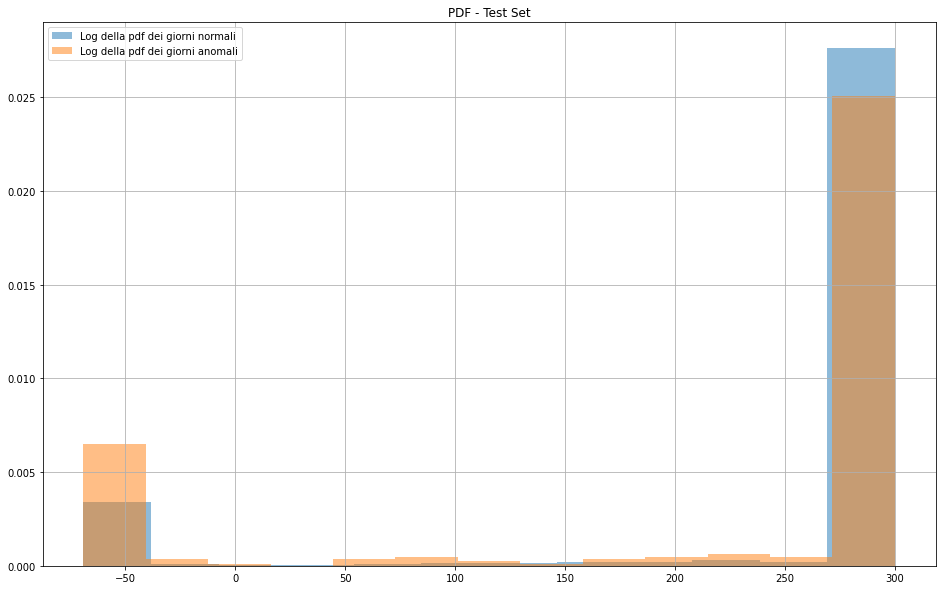

In [185]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob_holidays = scipy.stats.multivariate_normal.pdf(ans['res_test'][ans['holidays_test'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(np.clip(np.log(prob_holidays+1e-30), -100, 300), label='Log della pdf dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Test Set')
plt.show()

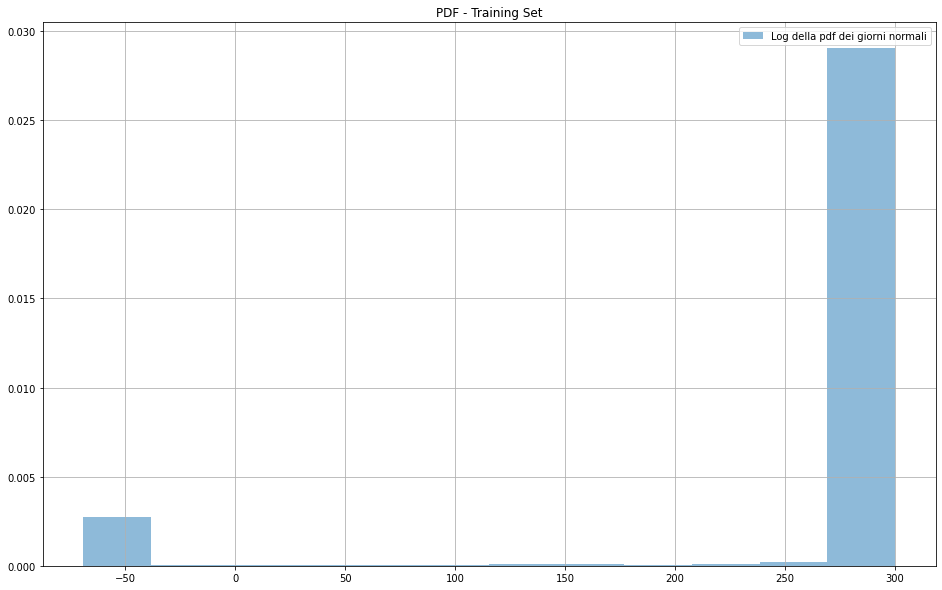

In [186]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_train'], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Training Set')
plt.show()

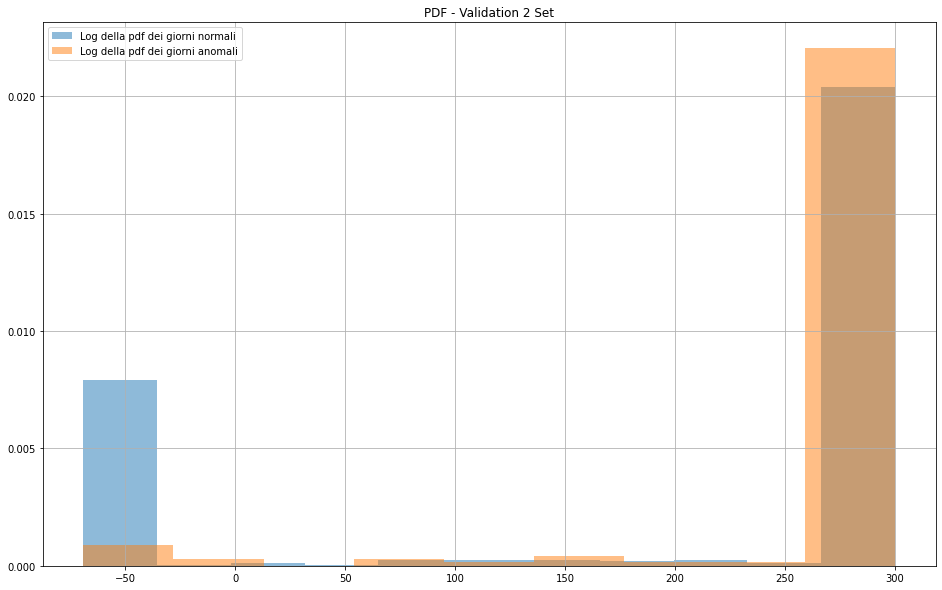

In [187]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 0], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob_holidays = scipy.stats.multivariate_normal.pdf(ans['res_val2'][ans['holidays_val2'] == 1], mean=ans['mean'], cov=ans['cov'], allow_singular=True)

ax.hist(np.clip(np.log(prob_normaldays+1e-30), -100, 300), label='Log della pdf dei giorni normali', bins='auto', density=True, alpha=0.5)
ax.hist(np.clip(np.log(prob_holidays+1e-30), -100, 300), label='Log della pdf dei giorni anomali', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
ax.set_title('PDF - Validation 2 Set')
plt.show()

In [188]:
best_idx = np.argmin(abs(ans['mean']))
best_idx, np.argsort(abs(ans['mean']))

(49,
 array([49, 64, 48, 32, 31, 50, 47, 30, 46, 33, 51, 41, 45, 34, 40, 18, 35,
        36, 44, 29, 19, 23, 27, 37, 42, 52, 22, 28, 24, 43, 39, 26, 25, 21,
        16, 17, 38, 63, 20, 78, 15,  5, 53,  6, 10,  7,  9,  4,  8, 55, 11,
        54, 56, 12,  3, 14,  0, 13, 57,  2,  1, 58, 62, 59, 60, 61, 65, 79,
        80, 66, 77, 81, 82, 83, 67, 76, 68, 69, 75, 70, 71, 72, 74, 73],
       dtype=int64))

Le tre celle sottostanti mostrano i valori previsti e quelli reali assieme alle metriche usate per separare le distribuzioni.<br>
In particolare, possiamo osservare come il modello preveda correttamente i giorni normali, mentre mostra risultati molto peggiori per i giorni anomali. Questa differenza traspare anche attraverso le metriche utilizzate.<br>
<b>Nota:</b> Il modello realizza diverse previsioni, quella mostrata nel grafico è quella con minore valore assoluto della media.

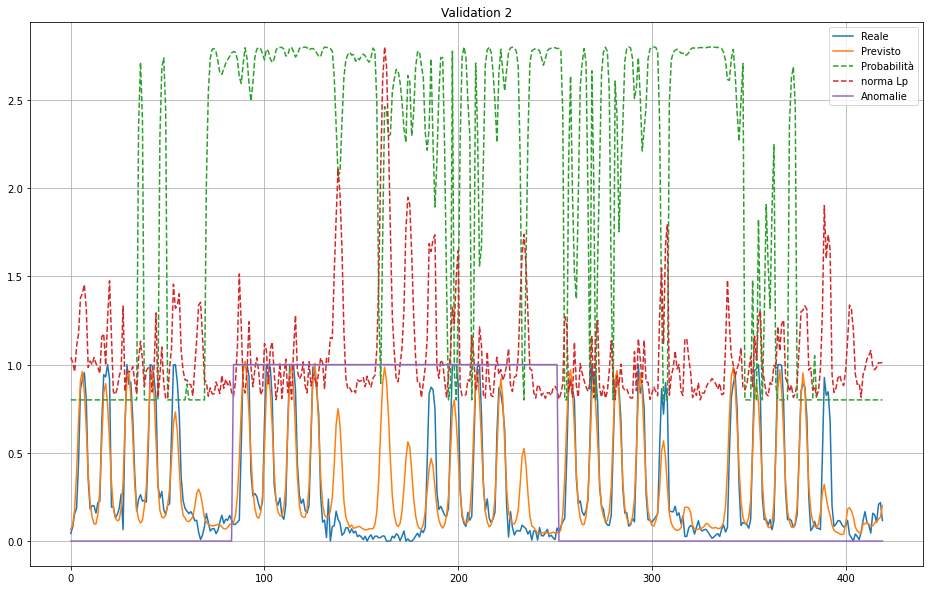

In [189]:
## val2 data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

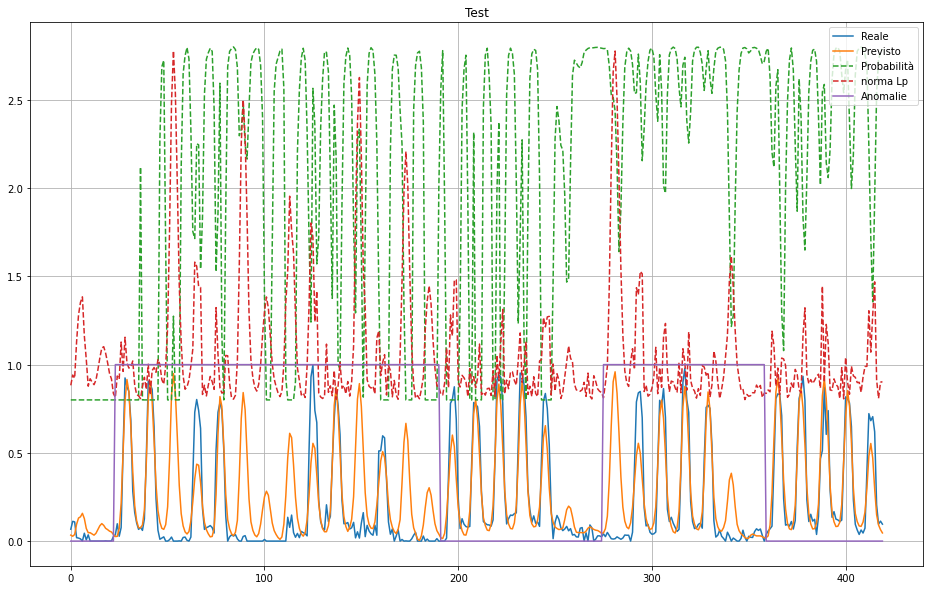

In [190]:
## test data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_test'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_test'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_test_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_test'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_test'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_test'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

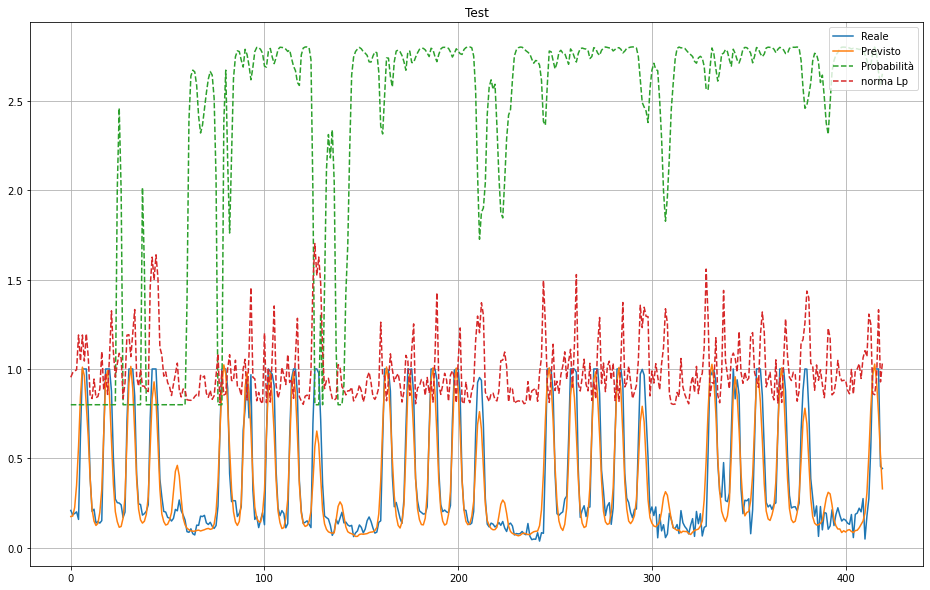

In [191]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

Le due celle sottostanti mostrano le due metriche utilizzate:
* Probabilità: calcola la pdf gaussiana (con media e covarianza da val1) del residuo
* L2: calcola la norma L2 del residuo

Possiamo osservare come il secondo metodo risulti essere il migliore nella metrica considerata $F_{0.1}$

threshold: 4.0167772265778314e+237 (508/805) - f0.1: 0.24424158152469622 - f0.1(validation): 0.21865587349397594
{'auc': 0.5845790715971676, 'accuracy': 0.35714285714285715, 'recall': 0.975609756097561, 'precision': 0.24242424242424243}

              precision    recall  f1-score   support

           0       0.97      0.19      0.32       155
           1       0.24      0.98      0.39        41

    accuracy                           0.36       196
   macro avg       0.61      0.58      0.36       196
weighted avg       0.82      0.36      0.34       196



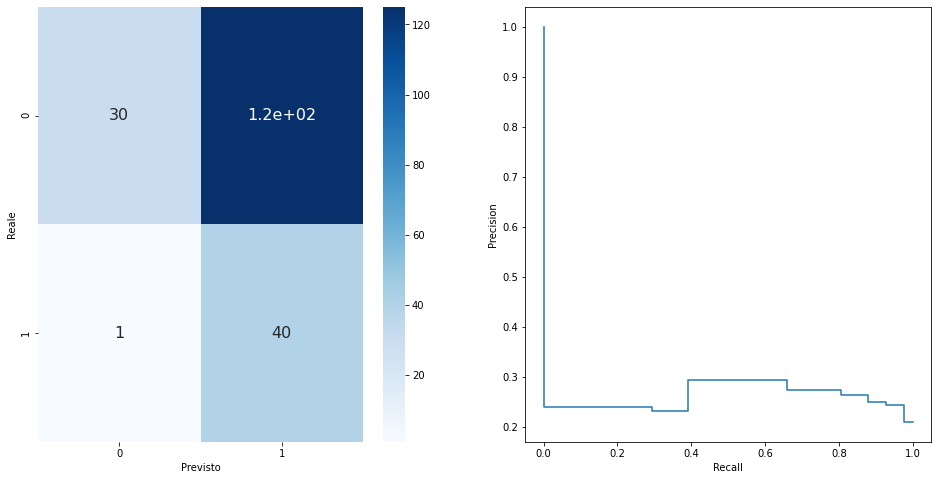

In [192]:
# Probabilità
print_results(ans, True, distance_metric='prob')

threshold: 7.092632323061683 (801/805) - f0.1: 0.9334565619223659 - f0.1(validation): 0.8145161290322581
{'auc': 0.5609756097560976, 'accuracy': 0.8163265306122449, 'recall': 0.12195121951219512, 'precision': 1.0}

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       155
           1       1.00      0.12      0.22        41

    accuracy                           0.82       196
   macro avg       0.91      0.56      0.56       196
weighted avg       0.85      0.82      0.75       196



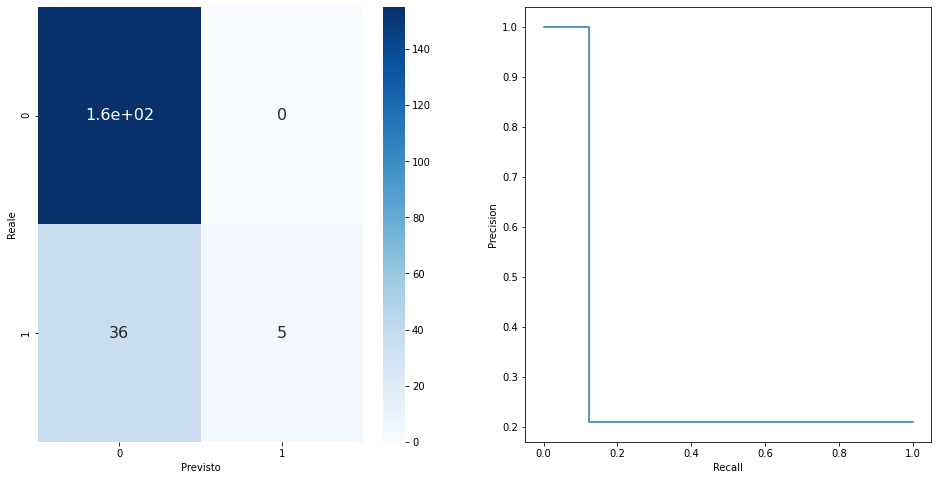

In [193]:
# Norma L2
print_results(ans, True, distance_metric=2)

### Second Floor
Questo dataset rispetto a quello dei Paesi Bassi possiede molti più trend (sia settimanali che stagionali), di conseguenza risulta più complicato e molto più difficile ottenere previsioni consistenti (in particolare nei weekend e durante la notte). Il modello usato per questo dataset ha molti più parametri rispetto al modello usato per il dataset dei Paesi Bassi, ma anche tecniche di regolarizzazione più potenti (dropout rate maggiore).

In [194]:
df = pd.read_pickle('train1.pkl')
df

,AvgP1,AvgT,AvgH,AvgP2,AvgP3,DateTime,holidays,dayofweek
DateTime,,,,,,,,
2017-02-08 00:00:00,35.0,4.30,94.199997,34.0,87.0,2017-02-08 00:00:00,0,2
2017-02-08 00:15:00,0.0,4.80,94.550003,0.0,0.0,2017-02-08 00:15:00,0,2
2017-02-08 00:30:00,0.0,5.40,94.800003,51.0,0.0,2017-02-08 00:30:00,0,2
2017-02-08 00:45:00,0.0,5.40,94.449997,0.0,83.0,2017-02-08 00:45:00,0,2
2017-02-08 01:00:00,53.0,5.50,94.199997,0.0,0.0,2017-02-08 01:00:00,0,2
...,...,...,...,...,...,...,...,...
2019-04-09 22:45:00,41.0,10.95,83.250000,41.0,65.0,2019-04-09 22:45:00,0,1
2019-04-09 23:00:00,42.0,10.80,84.599998,42.0,68.0,2019-04-09 23:00:00,0,1
2019-04-09 23:15:00,43.0,10.65,86.050003,43.0,72.0,2019-04-09 23:15:00,0,1


In [195]:
params = {'dense_activation': 'swish',
          'dropout_rate': 0.45,
          'ensemble': 5,
          'hidden_unit': 100,
          'inp_dropout': 0.0,
          'inp_noise': 0.2,
          'loss': 'mse',
          'recurrent': 'lstm',
          'units': [80, 30, 50]
}

In [196]:
gc.collect()

256169

In [197]:
if HYPERTUNE:
    df_x, df_y = df['AvgP1'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
gc.collect()
best

In [ ]:
ans = run(df['AvgP1'].to_numpy(), df['holidays'].to_numpy(), params=params)

61824 14112
x_train: (2363, 168, 1)
x_val1: (920, 168, 1)
x_val2: (2482, 168, 1)
x_test: (3547, 168, 1)
Epoch 1/1000
5/5 [==============================] - 143s 23s/step - loss: 0.2547 - mse: 0.2547 - mape: 23492732.0365 - mae: 0.3794 - val_loss: 0.1639 - val_mse: 0.1639 - val_mape: 8249998.0000 - val_mae: 0.3084
Epoch 2/1000
5/5 [==============================] - 105s 21s/step - loss: 0.1178 - mse: 0.1178 - mape: 18256140.1667 - mae: 0.2624 - val_loss: 0.1065 - val_mse: 0.1065 - val_mape: 23641066.0000 - val_mae: 0.2831

In [ ]:
for metric, val_metric in [('mse', 'val_mse'), ('mse', 'val_mse'), ('mape', 'val_mape')]:
    print(f"{metric.rjust(8)}: {str(round(ans[metric], 3)).rjust(8)} - {str(round(ans[val_metric], 3)).rjust(8)}")

#### Media e covarianza del residuo

In [ ]:
#mean graph
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

In [ ]:
#convariance matrix

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])} det: {np.linalg.det(ans["cov"])} min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

#### Confronta tra giorni normali e giorni anomali
Nel grafico sottostante possiamo osservare come i giorni anomali tendano ad avere una norma maggiore rispetto ai giorni normali.

In [ ]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
prob_normaldays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 0], axis=1, ord=2)
prob_holidays = np.linalg.norm(ans['res_test'][ans['holidays_test'] == 1], axis=1, ord=2)

ax.hist(prob_normaldays, label='distance of normal days', bins='auto', density=True, alpha=0.5)
ax.hist(prob_holidays, label='distance of holidays', bins='auto', density=True, alpha=0.5)

ax.grid()
ax.legend()
plt.show()

In [ ]:
best_idx = np.argmin(abs(ans['mean']))
best_idx, np.argsort(abs(ans['mean']))

Possiamo notare che il modello non riesca a prevedere correttamente i giorni anomali, mentre riesca a prevedere meglio i giorni normali.
Tuttavia, questo dataset è più complesso rispetto al dataset dei Paesi Bassi, quindi il modello tende ad essere molto meno preciso, in particolare nel weekend e durante la notte.

In [ ]:
## val2 data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

In [ ]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

In [ ]:
# Probabilità
print_results(ans, True, distance_metric='prob')

In [ ]:
#Norma L2
print_results(ans, True, distance_metric=2)

### Third Floor
Il terzo dataset risulta essere molto più caotico e difficile da prevedere. Infatti, possiamo osservare come il modello non riesca ad apprendere completamente lo schema. Ne conseguono pessimi risultati in tutte le metriche considerate. Al contrario dei dataset precedenti la likelihood mostra risultati leggermente migliori, probabilmente questo fenomeno avviene perché la likelihood riesce a pesare meglio gli errori.

In [ ]:
df = pd.read_pickle('train1.pkl')

In [ ]:
params = {'dense_activation': 'swish',
          'dropout_rate': 0.1,
          'ensemble': 4,
          'hidden_unit': 128,
          'inp_dropout': 0.0,
          'inp_noise': 0.2,
          'loss': 'mse',
          'recurrent': 'lstm',
          'units': [160]
}

In [ ]:
if HYPERTUNE:
    df_x, df_y = df['AvgP3'].to_numpy(), df['holidays'].to_numpy()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=40)
else:
    best = None
tf.keras.backend.clear_session()
gc.collect()
best

In [ ]:
ans = run(df['AvgP3'].to_numpy(), df['holidays'].to_numpy(), params=params)

In [ ]:
for metric in ['mse', 'val_mse', 'mae', 'val_mae', 'mape', 'val_mape']:
    print(f"{metric.rjust(8)}: {round(np.mean(ans[metric]), 3)} +- {round(np.std(ans[metric]), 3)}")

#### Media e covarianza del residuo
Sia nella matrice di covarianza che nel vettore delle medie possiamo notare che ha un pattern correlato ai giorni. Ipotizzo che sia dovuto principalmente alle difficoltà del modello nel prevedere l'esatta altezza del picco del giorno.

In [ ]:
#mean graph
fig, ax = plt.subplots(ncols=1, figsize=FIG_SIZE)
ax.plot(ans['mean'], label=f'mean')
ax.grid()
ax.legend()
plt.show()

In [ ]:
#convariance matrix

print(f'rank: {np.linalg.matrix_rank(ans["cov"])}/{len(ans["cov"])} det: {np.linalg.det(ans["cov"])} min(eigvals): {np.min(np.linalg.eigvals(ans["cov"]))}')

fig, ax = plt.subplots(figsize=FIG_SIZE)
cax = ax.matshow(ans['cov'])
ax.grid()
cbar = fig.colorbar(cax)
plt.show()

#### Confronta tra giorni normali e giorni anomali

In [ ]:
## val2 data
best_idx = 0
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_val2'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_val2'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_val2_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_val2'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)
prob_test = prob.copy()

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = prob + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_val2'][lower:upper], axis=1)
norm_test = prob.copy()
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.plot(ans['holidays_val2'][lower:upper], label='Anomalie', alpha=1.0)

ax.grid()
ax.legend(loc='upper right')
ax.set_title('Validation 2')
plt.show()

In [ ]:
## train data
lower = DAY * 0
upper = lower + DAY * 35
pos = ans['cnt_train'][lower:upper]
fig, ax = plt.subplots(figsize=FIG_SIZE)

ax.plot([i[best_idx] for i in ans['y_train'][lower:upper]], label='Reale')
ax.plot([i[best_idx] for i in ans['y_train_pred'][lower:upper]], label='Previsto')

prob = scipy.stats.multivariate_normal.pdf(ans['res_train'][lower:upper], mean=ans['mean'], cov=ans['cov'], allow_singular=True)
prob[~np.isfinite(prob)] = 1e300
prob = np.log(prob + 1e-30)

prob = 2 * (prob - prob_test.min()) / (prob_test.max() - prob_test.min())
prob = np.clip(prob, -0.5, 4.0) + 0.8
ax.plot(prob, label='Probabilità', linestyle='dashed')

prob = np.linalg.norm(ans['res_train'][lower:upper], axis=1)
prob = 2 * (prob - norm_test.min()) / (norm_test.max() - norm_test.min())
prob = prob + 0.8
ax.plot(prob, label='norma Lp', linestyle='dashed')


ax.grid()
ax.legend(loc='upper right')
ax.set_title('Test')
plt.show()

In [ ]:
# Probabilità
print_results(ans, True, distance_metric='prob')

In [ ]:
#Norma L2
print_results(ans, True, distance_metric=2)